First:
- Creates a digital twin manager using your trained model and disease names.
- Generates a random genetic profile (with np.random.randn(model.P)). This is just a vector of random numbers, not a real person’s genetics.
- Creates a digital twin for this random profile using twin_manager.create_twin(random_genetic_profile). This simulates what the model would predict for a hypothetical person with those genetics.
- Plot the trajectories (signature proportions and disease probabilities) for this synthetic individual.

In [1]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()


Loading components...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50273/432458031.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/va

Loaded all components successfully!


In [3]:
# If essentials['disease_names'] is a DataFrame:
import pandas as pd
if isinstance(essentials['disease_names'], pd.DataFrame):
    disease_names = essentials['disease_names'].iloc[:, 0].tolist()
else:
    disease_names = list(essentials['disease_names'])

# Find the index for "Type 2 diabetes"
diabetes_idx = [i for i, name in enumerate(disease_names) if name.lower() == "type 2 diabetes"][0]
print("Type 2 diabetes index:", diabetes_idx)

Type 2 diabetes index: 47


In [1]:

import torch
import numpy as np
from event_analysis import (
    analyze_disease_event,
    plot_event_analysis,
    find_matched_pairs,
    plot_matched_pairs
)

# Load your trained model
model_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_0_10000/model.pt'
checkpoint = torch.load(model_path)

# Initialize model (using your existing initialization code)
from clust_huge_amp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest

# Load references
refs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']

# Create model
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=checkpoint['hyperparameters']['N'],
    D=checkpoint['hyperparameters']['D'],
    T=checkpoint['hyperparameters']['T'],
    K=20,
    P=checkpoint['hyperparameters']['P'],
    G=checkpoint['G'],
    Y=checkpoint['Y'],
    prevalence_t=checkpoint['prevalence_t'],
    disease_names=checkpoint['disease_names'],
    init_sd_scaler=1e-1,
    genetic_scale=1,
    W=0.0001,
    R=0,
    signature_references=signature_refs,
    healthy_reference=True
)

# Load initial psi and clusters
initial_psi = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_clusters_400k.pt')

# Initialize model
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Example: Analyze a specific disease
disease_idx = 112  # Example: Myocardial Infarction
disease_name = model.disease_names[0][disease_idx]


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_39224/2837478127.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/var/fol


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.8155, -13.8155, -13.1095, -12.4036, -12.4036])
Base value centered (first 5): tensor([-0.3723, -0.3723,  0.3336,  1.0396,  1.0396])
Base value centered mean: 6.57081614008348e-07
Gamma init for k=0 (first 5): tensor([ 0.0009,  0.0069,  0.0118,  0.0153, -0.0106])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_39224/2837478127.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/


Calculating gamma for k=0:
Number of diseases in cluster: 16.0
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -11.9623, -13.8155])
Base value centered (first 5): tensor([-0.1879, -0.1879, -0.1879,  1.6653, -0.1879])
Base value centered mean: -3.345489574257954e-07
Gamma init for k=0 (first 5): tensor([ 0.0072,  0.0061, -0.0051,  0.0064,  0.0244])

Calculating gamma for k=1:
Number of diseases in cluster: 21.0
Base value (first 5): tensor([-13.3449, -13.8155, -13.3449, -13.3449, -12.4036])
Base value centered (first 5): tensor([ 0.1505, -0.3201,  0.1505,  0.1505,  1.0918])
Base value centered mean: -1.8495559288567165e-06
Gamma init for k=1 (first 5): tensor([0.0041, 0.0016, 0.0004, 0.0024, 0.0014])

Calculating gamma for k=2:
Number of diseases in cluster: 15.0
Base value (first 5): tensor([-13.8155, -13.8155, -13.1566, -11.8388, -12.4977])
Base value centered (first 5): tensor([-0.3849, -0.3849,  0.2740,  1.5918,  0.9329])
Base value centered mean: 9.290695288655115e-07



Analyzing disease: Myocardial infarction

Analyzing disease events...


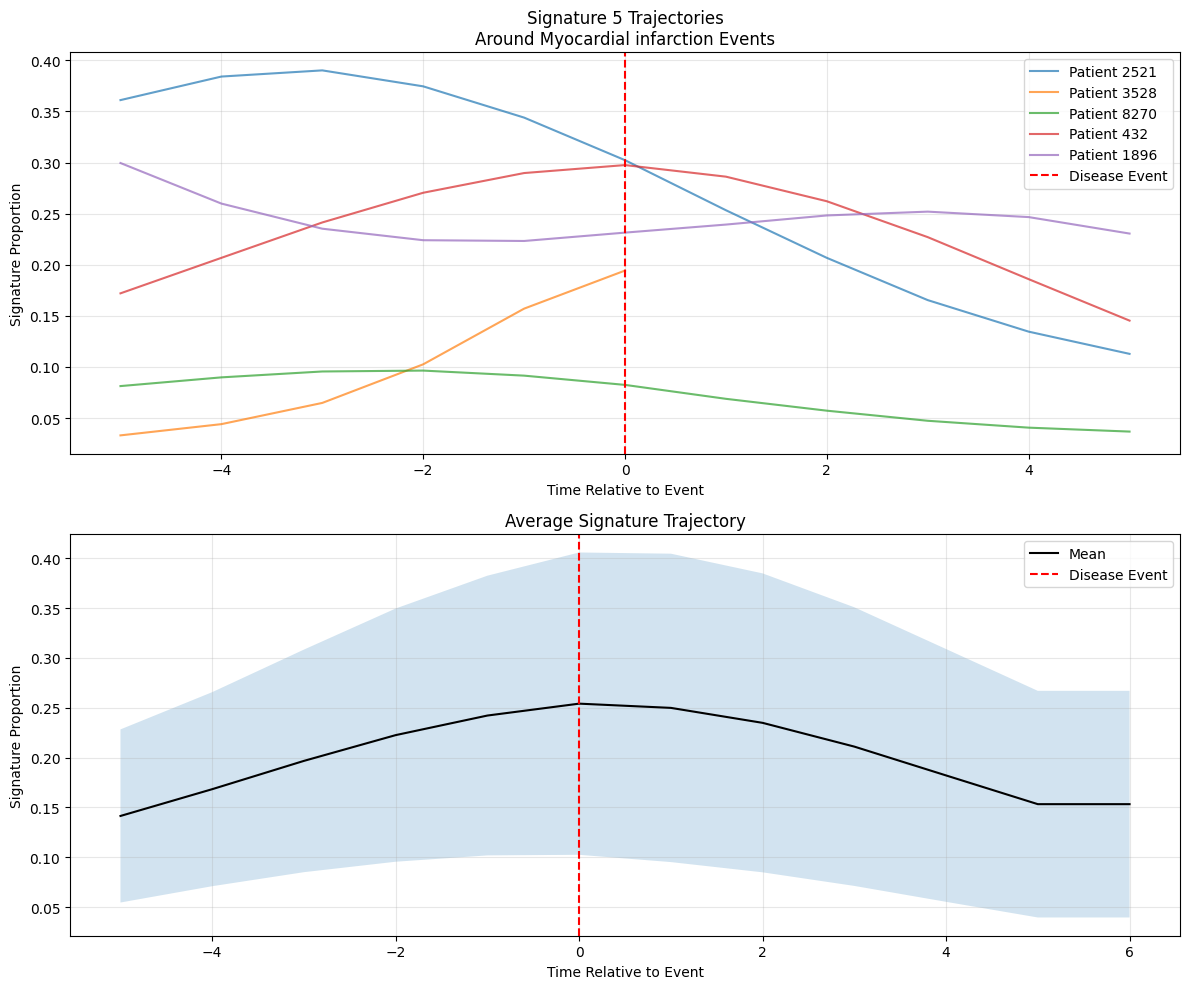


Finding matched pairs...


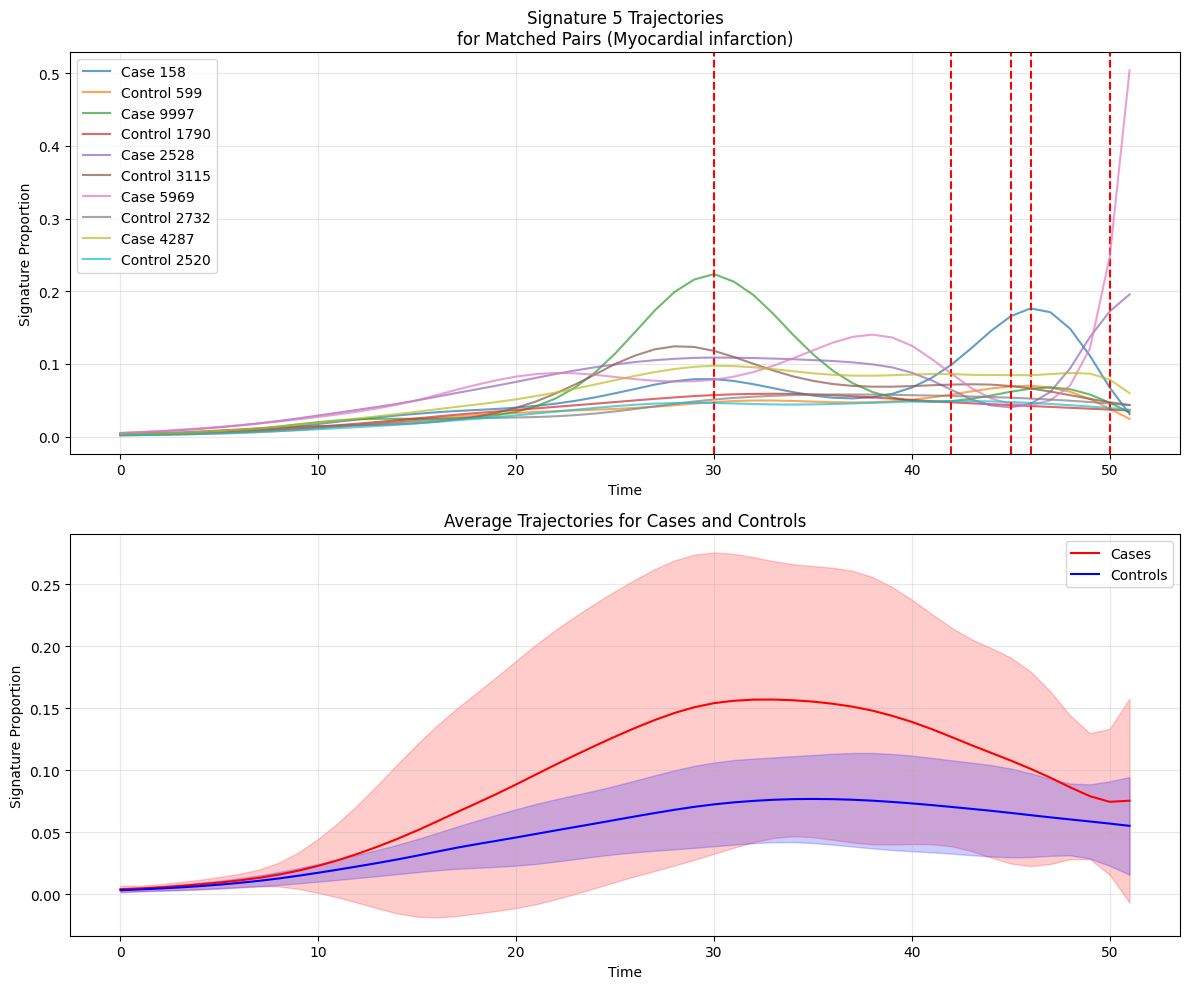


Summary Statistics:
Number of disease events: 635
Number of matched pairs: 635
Most specific signature: 5

Average change in signature proportion at event time: 0.012 ± 0.035


In [2]:

print(f"\nAnalyzing disease: {disease_name}")

# 1. Analyze disease events
print("\nAnalyzing disease events...")
event_results = analyze_disease_event(model, disease_idx, window_size=5)
if event_results:
    plot_event_analysis(event_results, disease_name, n_samples=5)

# 2. Find and analyze matched pairs
print("\nFinding matched pairs...")
matched_results = find_matched_pairs(model, disease_idx, baseline_time=0, n_neighbors=5)
if matched_results:
    plot_matched_pairs(matched_results, disease_name, n_samples=5, T=model.T)

# Print summary statistics
if event_results and matched_results:
    print("\nSummary Statistics:")
    print(f"Number of disease events: {len(event_results['patients'])}")
    print(f"Number of matched pairs: {len(matched_results['pairs'])}")
    print(f"Most specific signature: {event_results['specific_signature']}")
    
    # Calculate average change in signature proportion
    case_trajs = np.array([p['case_trajectory'] for p in matched_results['pairs']])
    control_trajs = np.array([p['control_trajectory'] for p in matched_results['pairs']])
    
    # Calculate change at event time
    event_changes = []
    for pair in matched_results['pairs']:
        event_time = pair['event_time']
        case_change = pair['case_trajectory'][event_time] - pair['case_trajectory'][event_time-1]
        control_change = pair['control_trajectory'][event_time] - pair['control_trajectory'][event_time-1]
        event_changes.append(case_change - control_change)
    
    print(f"\nAverage change in signature proportion at event time: {np.mean(event_changes):.3f} ± {np.std(event_changes):.3f}")


In [3]:
import pandas as pd
prescription = pd.read_csv('prescriptions.csv')

In [4]:
prescription.head()

,eid,from,to,category,type
0,1000198,2013-06-24,2015-01-19,anti_hypertensives,any
1,1000198,2015-01-26,2017-07-03,anti_hypertensives,any
2,1000232,2011-06-28,2011-09-25,anti_hypertensives,any
3,1000273,2003-11-24,2004-02-21,anti_hypertensives,any
4,1000273,2004-07-09,2005-12-26,anti_hypertensives,any


In [5]:
import pandas as pd
import numpy as np

# Load prescription and covariate data
prescription = pd.read_csv('prescription.csv')
cov = pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox/for_regenie/ukbb_covariates_400k.txt', sep=' ')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid', cov.columns[2]: 'year_of_birth'})

# Choose drug class
drug_class = 'anti_hypertensives'

# 1. Identify treated individuals and their first exposure date
treated = prescription[prescription['category'] == drug_class]
treated['from'] = pd.to_datetime(treated['from'])
first_exposure = treated.groupby('eid')['from'].min().reset_index()
first_exposure = first_exposure.merge(cov[['eid', 'year_of_birth']], on='eid', how='left')

# 2. Calculate age at first exposure
first_exposure['age_at_exposure'] = first_exposure['from'].dt.year - first_exposure['year_of_birth']

# 3. Map to model time index (assuming model time is years since birth)
# If your model time grid is 0,1,...,51 for 52 years:
time_grid = np.arange(52)
first_exposure['time_index'] = first_exposure['age_at_exposure'].apply(lambda age: np.argmin(np.abs(time_grid - age)))

# Now you have for each treated individual:
# - eid
# - age_at_exposure
# - time_index (in model lambda array)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_39224/1156455315.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated['from'] = pd.to_datetime(treated['from'])


In [10]:
import os
import glob
import numpy as np
import torch
import re



# List all output directories and sort them properly by their index numbers
def sort_by_index(dir_name):
    # Extract just the start number from directory name
    # e.g., from 'output_10000_20000_20241225_062028' get '10000'
    match = re.search(r'output_(\d+)_\d+', dir_name)
    if match:
        return int(match.group(1))
    return 0

base_dir='/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results'

# Test the sorting
output_dirs = sorted(glob.glob(os.path.join(base_dir, 'output_*')), key=sort_by_index)

# Print first few directories to verify sorting
print("Verifying directory sorting:")
for dir_path in output_dirs[:5]:
    print(dir_path)


# Initialize the full array
all_lambdas = np.zeros((400000, 21, 52))  # [n_individuals, n_signatures, n_timepoints]

# Keep track of processed indices
processed_ranges = []

# Load and combine lambda from each model
current_idx = 0
for dir_path in output_dirs:
    model_path = os.path.join(dir_path, 'model.pt')
    try:
        # Extract batch range from directory name
        batch_range = re.findall(r'output_(\d+)_(\d+)', os.path.basename(dir_path))
        if batch_range:
            start_idx, end_idx = map(int, batch_range[0])
            print(f"\nProcessing batch {start_idx}-{end_idx}")
            
            # Verify this matches our current_idx
            if current_idx != start_idx:
                print(f"WARNING: Index mismatch! current_idx={current_idx}, but batch starts at {start_idx}")
        
        # Load the saved model
        checkpoint = torch.load(model_path)
        
        # Extract lambda
        if 'model_state_dict' in checkpoint:
            lambda_values = checkpoint['model_state_dict']['lambda_']
        else:
            lambda_values = checkpoint['lambda_']
            
        # Convert to numpy if it's a tensor
        if torch.is_tensor(lambda_values):
            lambda_values = lambda_values.detach().cpu().numpy()
        
        # Get batch size
        batch_size = lambda_values.shape[0]
        
        # Add to the full array
        all_lambdas[current_idx:current_idx + batch_size] = lambda_values
        
        # Store processed range
        processed_ranges.append((current_idx, current_idx + batch_size))
        
        print(f"Loaded lambda from {dir_path}")
        print(f"Batch size: {batch_size}")
        print(f"Current index range: {current_idx} to {current_idx + batch_size}")
        
        current_idx += batch_size
        
    except Exception as e:
        print(f"Error loading from {dir_path}: {e}")

# Verify no gaps or overlaps in processed ranges
processed_ranges.sort()
for i in range(len(processed_ranges)-1):
    if processed_ranges[i][1] != processed_ranges[i+1][0]:
        print(f"WARNING: Gap or overlap between batches! {processed_ranges[i]} and {processed_ranges[i+1]}")

# Save the combined lambdas
#np.save('all_lambdas_combined.npy', all_lambdas)

# Print final verification
print("\nFinal verification:")
print("Shape of all_lambdas:", all_lambdas.shape)
print("Total individuals processed:", current_idx)
print("Processed ranges:", processed_ranges)

# Load patient IDs and verify length matches
patient_ids = np.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/patient_ids.npy')
# Verify dimensions
print("Total available patient IDs:", len(patient_ids))  # Should be 407,878
print("Processed lambda shape:", all_lambdas.shape)      # Should be (400000, 20, 52)

# Create mapping of processed IDs
processed_ids = patient_ids[:400000]  # Get just the first 400K IDs we processed
print("\nVerification of processed IDs:")
print("Number of processed IDs:", len(processed_ids))
print("First few IDs:", processed_ids[:5])
print("Last few IDs:", processed_ids[-5:])

# Save the processed IDs mapping
np.save('processed_patient_ids.npy', processed_ids)

# Print some stats about unprocessed patients
unprocessed_ids = patient_ids[400000:]
print("\nUnprocessed patients:")
print("Number of unprocessed IDs:", len(unprocessed_ids))
print("First few unprocessed IDs:", unprocessed_ids[:5])

Verifying directory sorting:
/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_0_10000
/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_10000_20000
/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_20000_30000
/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_30000_40000
/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_40000_50000

Processing batch 0-10000
Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_0_10000
Batch size: 10000
Current index range: 0 to 10000

Processing batch 10000-20000


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50273/3681310233.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_10000_20000
Batch size: 10000
Current index range: 10000 to 20000

Processing batch 20000-30000
Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_20000_30000
Batch size: 10000
Current index range: 20000 to 30000

Processing batch 30000-40000
Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_30000_40000
Batch size: 10000
Current index range: 30000 to 40000

Processing batch 40000-50000
Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_40000_50000
Batch size: 10000
Current index range: 40000 to 50000

Processing batch 50000-60000
Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_50000_60000
Batch size: 10000
Current index range: 50000 to 60000

Processing batch 60000-70000
Loaded lambda from /Users/sarahurbut/Lib

In [11]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# 1. Load data
prescriptions = pd.read_csv('prescriptions.csv')
cov = pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox/for_regenie/ukbb_covariates_400k.txt', sep=' ')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid', cov.columns[2]: 'year_of_birth'})

def softmax(x):
    """
    Compute softmax values for each set of scores in x.
    x shape: (n_individuals, n_signatures, n_timepoints)
    """
    # Reshape to (n_individuals * n_timepoints, n_signatures)
    x_reshaped = x.transpose(0, 2, 1).reshape(-1, x.shape[1])
    
    # Compute softmax
    e_x = np.exp(x_reshaped - np.max(x_reshaped, axis=1, keepdims=True))
    softmax_x = e_x / np.sum(e_x, axis=1, keepdims=True)
    
    # Reshape back to original shape
    return softmax_x.reshape(x.shape[0], x.shape[2], x.shape[1]).transpose(0, 2, 1)

# Calculate thetas using softmax
lambdas = softmax(all_lambdas)  # shape: (400000, 20, 52)

processed_ids = np.load('processed_patient_ids.npy')  # shape: (400000,)



# For each treated, calculate model time index of first prescription
def get_time_index(yob, presc_date, time_grid):
    if pd.isnull(yob) or pd.isnull(presc_date):
        return None
    age_at_presc = presc_date.year - yob
    return int(np.argmin(np.abs(time_grid +30- age_at_presc)))



        


In [12]:

# 2. Map drug class to signature
drug_class_to_signature = {
    'statins': 5,
    'anti_hypertensives': 0,
    'diabetes': 15,
    'antipsychotics': 7,
    'steroids': 16
}
drug = 'diabetes'  # Example: change as needed
sig_idx = drug_class_to_signature[drug]

print(sig_idx)
      

15


In [13]:

# Ensure all IDs are int for matching
processed_ids = processed_ids.astype(int)
prescriptions['eid'] = prescriptions['eid'].astype(int)
cov['eid'] = cov['eid'].astype(int)

# Get year of birth for all
eid_to_yob = dict(zip(cov['eid'], cov['year_of_birth']))

# For each treated, get first prescription date

prescriptions['from'] = pd.to_datetime(prescriptions['from'])
treated_first_presc = prescriptions[prescriptions['category'] == drug].groupby('eid')['from'].min()


# 3. Identify treated and untreated
treated_eids = prescriptions.loc[prescriptions['category'] == drug, 'eid'].unique()
untreated_eids = np.setdiff1d(processed_ids, treated_eids)

time_grid = np.arange(lambdas.shape[2])  # e.g., 0-51 for 52 years
treated_time_idx = {}
for eid, presc_date in treated_first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    idx = get_time_index(yob, presc_date, time_grid)
    if idx is not None:
        treated_time_idx[int(eid)] = idx
# Get indices
treated_indices = [np.where(processed_ids == eid)[0][0] for eid in treated_time_idx.keys() if eid in processed_ids]
untreated_indices = [np.where(processed_ids == eid)[0][0] for eid in untreated_eids if eid in processed_ids]

print(f"Number of treated: {len(treated_indices)}")
print(f"Number of untreated: {len(untreated_indices)}")
print('Sample processed_ids:', processed_ids[:5])
print('Sample treated_eids:', treated_eids[:5])
print('Sample untreated_eids:', untreated_eids[:5])


Number of treated: 14791
Number of untreated: 385209
Sample processed_ids: [1000015 1000023 1000037 1000042 1000059]
Sample treated_eids: [1000198 1000273 1000340 1000780 1001109]
Sample untreated_eids: [1000015 1000023 1000037 1000042 1000059]


In [16]:


def run_digital_twin_matching(
    treated_time_idx,
    untreated_eids,
    processed_ids,
    lambdas,
    Y,
    diabetes_idx=47,
    window=10,
    window_post=10,
    sig_idx=15,
    sample_size=1000
):
    """
    Match each treated individual to a control by signature trajectory in the years prior to drug start,
    then compare post-treatment Type 2 diabetes event rates and signature trajectories.
    For each treated, only a random sample of controls (sample_size) is considered.
    
    Parameters:
        treated_time_idx: dict {eid: t0} for treated patients
        untreated_eids: list of EIDs who have not started the drug (or started much later)
        processed_ids: numpy array of patient IDs (strings or ints)
        lambdas: (N, n_signatures, n_timepoints) array (already softmaxed)
        Y: event tensor (N, n_diseases, n_timepoints)
        diabetes_idx: index of Type 2 diabetes in Y (default 47)
        window: years before t0 for matching (default 10)
        window_post: years after t0 for outcome (default 10)
        sig_idx: signature index to plot (default 15)
        sample_size: number of controls to sample for each treated (default 1000)
    """
    matched_pairs = []

    for treated_eid, t0 in treated_time_idx.items():
        # Find index in processed_ids
        try:
            treated_idx = np.where(processed_ids == int(treated_eid))[0][0]
        except Exception:
            continue
        if t0 < window:
            continue  # Not enough history
        traj_treated = lambdas[treated_idx, :, t0-window:t0].flatten()  # shape: (n_sigs * window,)

        # Sample controls
        if len(untreated_eids) > sample_size:
            sampled_controls = random.sample(list(untreated_eids), sample_size)
        else:
            sampled_controls = untreated_eids

        control_trajs = []
        control_indices = []
        for eid in sampled_controls:
            try:
                idx = np.where(processed_ids == int(eid))[0][0]
            except Exception:
                continue
            if t0 < window:
                continue
            traj_control = lambdas[idx, :, t0-window:t0].flatten()
            control_trajs.append(traj_control)
            control_indices.append(idx)
        if not control_trajs:
            continue
        control_trajs = np.array(control_trajs)
        dists = np.linalg.norm(control_trajs - traj_treated, axis=1)
        best_match_idx = np.argmin(dists)
        matched_pairs.append((treated_idx, control_indices[best_match_idx], t0))

    # Now, for each matched pair, compare post-t0 signature and event rates
    trajectories_treated = []
    trajectories_control = []
    diabetes_events_treated = []
    diabetes_events_control = []

    for treated_idx, control_idx, t0 in matched_pairs:
        t_end = min(lambdas.shape[2], t0 + window_post)
        traj_treated = lambdas[treated_idx, :, t0:t_end]
        traj_control = lambdas[control_idx, :, t0:t_end]
        trajectories_treated.append(traj_treated)
        trajectories_control.append(traj_control)
        # Event: did they get diabetes in the next window_post years?
        diabetes_event_treated = np.any(Y[treated_idx, diabetes_idx, t0:t_end] > 0)
        diabetes_event_control = np.any(Y[control_idx, diabetes_idx, t0:t_end] > 0)
        diabetes_events_treated.append(diabetes_event_treated)
        diabetes_events_control.append(diabetes_event_control)

    # Convert to arrays for analysis
    trajectories_treated = np.array(trajectories_treated)
    trajectories_control = np.array(trajectories_control)
    diabetes_events_treated = np.array(diabetes_events_treated)
    diabetes_events_control = np.array(diabetes_events_control)

    # Calculate event rates
    treated_event_rate = diabetes_events_treated.mean() if len(diabetes_events_treated) > 0 else float('nan')
    control_event_rate = diabetes_events_control.mean() if len(diabetes_events_control) > 0 else float('nan')
    print(f"Treated event rate: {treated_event_rate:.3f}")
    print(f"Control event rate: {control_event_rate:.3f}")

    # (Optional) Plot mean signature trajectory for a given signature index
    if trajectories_treated.shape[0] > 0:
        mean_treated = trajectories_treated[:, sig_idx, :].mean(axis=0)
        mean_control = trajectories_control[:, sig_idx, :].mean(axis=0)
        plt.plot(mean_treated, label='Treated')
        plt.plot(mean_control, label='Control')
        plt.legend()
        plt.title('Mean signature trajectory after t0')
        plt.show()
    else:
        print("No matched pairs found.")

    return {
        'matched_pairs': matched_pairs,
        'trajectories_treated': trajectories_treated,
        'trajectories_control': trajectories_control,
        'diabetes_events_treated': diabetes_events_treated,
        'diabetes_events_control': diabetes_events_control,
        'treated_event_rate': treated_event_rate,
        'control_event_rate': control_event_rate
    }



Current: Matching on a single signature (sig5) at treatment start.


In [44]:

%autoreload 2
from dt import *
import numpy as np


In [46]:

results = run_digital_twin_matching(
    treated_time_idx,
    untreated_eids,
    processed_ids,
    lambdas,
    Y,
    diabetes_idx=47,
    window=10,
    window_post=10,
    sig_idx=15,
    sample_size=10,
    max_cases=2# <--- Only process the first 1000 treated
)


Processing treated patient 1/2 (EID: 1000198) at time 35
t0: 35
treated_idx: 16
processed_ids: [1000015 1000023 1000037 ... 5929627 5929638 5929643]
shape of traj_treated:
(210,)
sampled_controls: [np.int64(3776544), np.int64(5516835), np.int64(1156962), np.int64(2395928), np.int64(2936253), np.int64(3973377), np.int64(3117158), np.int64(1921771), np.int64(2067944), np.int64(1623484)]
idx: 225344
sampled_controls eid: 3776544
shape of traj_control:
(210,)
idx: 366520
sampled_controls eid: 5516835
shape of traj_control:
(210,)
idx: 12703
sampled_controls eid: 1156962
shape of traj_control:
(210,)
idx: 113453
sampled_controls eid: 2395928
shape of traj_control:
(210,)
idx: 157235
sampled_controls eid: 2936253
shape of traj_control:
(210,)
idx: 241318
sampled_controls eid: 3973377
shape of traj_control:
(210,)
idx: 171899
sampled_controls eid: 3117158
shape of traj_control:
(210,)
idx: 74962
sampled_controls eid: 1921771
shape of traj_control:
(210,)
idx: 86817
sampled_controls eid: 20679

ValueError: too many values to unpack (expected 3)

Processed 500/14791 treated. Elapsed: 0.9 min. Est. remaining: 25.1 min.
Processed 1000/14791 treated. Elapsed: 1.7 min. Est. remaining: 23.9 min.
Processed 1500/14791 treated. Elapsed: 2.6 min. Est. remaining: 23.1 min.
Processed 2000/14791 treated. Elapsed: 3.5 min. Est. remaining: 22.2 min.
Processed 2500/14791 treated. Elapsed: 4.3 min. Est. remaining: 21.3 min.
Processed 3000/14791 treated. Elapsed: 5.2 min. Est. remaining: 20.4 min.
Processed 3500/14791 treated. Elapsed: 6.1 min. Est. remaining: 19.6 min.
Processed 4000/14791 treated. Elapsed: 6.9 min. Est. remaining: 18.7 min.
Processed 4500/14791 treated. Elapsed: 7.8 min. Est. remaining: 17.9 min.
Processed 5000/14791 treated. Elapsed: 8.7 min. Est. remaining: 17.0 min.
Processed 5500/14791 treated. Elapsed: 9.6 min. Est. remaining: 16.2 min.
Processed 6000/14791 treated. Elapsed: 10.4 min. Est. remaining: 15.3 min.
Processed 6500/14791 treated. Elapsed: 11.3 min. Est. remaining: 14.4 min.
Processed 7000/14791 treated. Elapsed

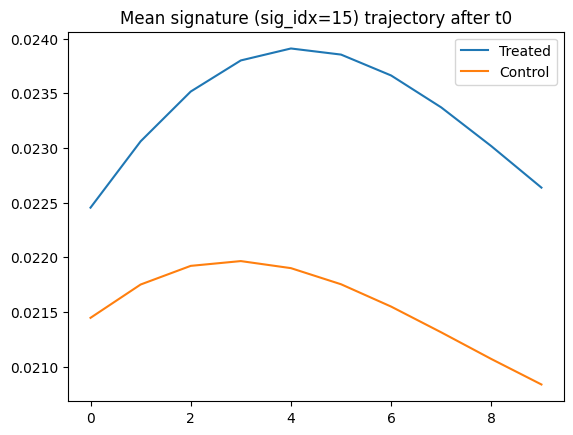

{'matched_pairs': [(np.int64(16), np.int64(301579), 35),
  (np.int64(20), np.int64(356105), 31),
  (np.int64(24), np.int64(39249), 37),
  (np.int64(57), np.int64(198568), 34),
  (np.int64(83), np.int64(317533), 19),
  (np.int64(87), np.int64(397828), 18),
  (np.int64(150), np.int64(185365), 22),
  (np.int64(151), np.int64(383637), 37),
  (np.int64(196), np.int64(299186), 26),
  (np.int64(220), np.int64(346815), 38),
  (np.int64(278), np.int64(105219), 24),
  (np.int64(279), np.int64(281397), 26),
  (np.int64(339), np.int64(278021), 31),
  (np.int64(348), np.int64(120338), 31),
  (np.int64(365), np.int64(76400), 19),
  (np.int64(402), np.int64(235947), 18),
  (np.int64(404), np.int64(221311), 41),
  (np.int64(436), np.int64(193287), 30),
  (np.int64(453), np.int64(134418), 12),
  (np.int64(491), np.int64(262715), 23),
  (np.int64(504), np.int64(140216), 43),
  (np.int64(510), np.int64(272094), 32),
  (np.int64(536), np.int64(275057), 35),
  (np.int64(556), np.int64(14610), 36),
  (np.in

In [36]:
run_digital_twin_matching_single_sig(
    treated_time_idx,
    untreated_eids,
    processed_ids,
    lambdas,
    Y,
    diabetes_idx=47,
    window=10,
    window_post=10,
    sig_idx=15,
    sample_size=1000,
    max_cases=None
)

In [30]:
from collections import defaultdict
t0_to_treated = defaultdict(list)
for eid in treated_time_idx.keys():
    t0 = treated_time_idx[eid]
    t0_to_treated[t0].append(eid)


treated_indices_final = []
untreated_indices_final = []
treated_eids_list = []
for t0, eids in t0_to_treated.items():
    batch_treated_indices = [np.where(processed_ids == eid)[0][0] for eid in eids]
    sig_treated = lambdas[batch_treated_indices, sig_idx, t0]  # shape: (n_batch,)
    valid_untreated_indices = [uidx for uidx in untreated_indices if t0 < lambdas.shape[2]]
    sig_untreated = lambdas[valid_untreated_indices, sig_idx, t0]  # shape: (n_untreated,)
    dists = np.abs(sig_treated[:, None] - sig_untreated[None, :])  # shape: (n_batch, n_untreated)
    match_idxs = np.argmin(dists, axis=1)
    for i, treated_idx in enumerate(batch_treated_indices):
        control_idx = valid_untreated_indices[match_idxs[i]]
        treated_indices_final.append(treated_idx)
        untreated_indices_final.append(control_idx)
        treated_eids_list.append(eids[i])

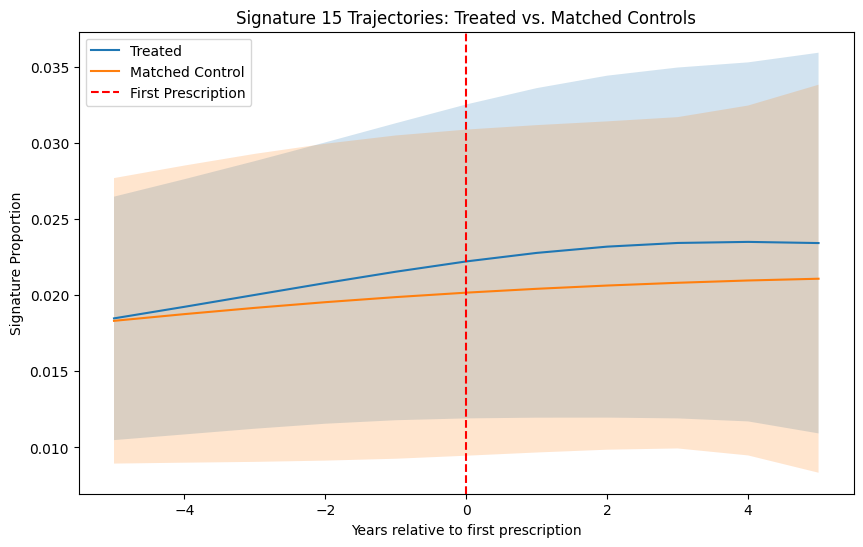

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
window = 5  # years before/after
desired_length = 2 * window + 1

trajectories_treated = []
trajectories_control = []
time_axes = []

for treated_idx, control_idx, eid in zip(treated_indices_final, untreated_indices_final, treated_eids_list):
    t0 = treated_time_idx[eid]
    t_start = max(0, t0 - window)
    t_end = min(lambdas.shape[2], t0 + window + 1)
    traj_treated = lambdas[treated_idx, sig_idx, t_start:t_end]
    # For control, align to same age window
    yob_control = eid_to_yob.get(int(processed_ids[control_idx]), None)
    yob_treated = eid_to_yob.get(int(processed_ids[treated_idx]), None)
    if yob_control is None or yob_treated is None:
        continue
    age_t0 = t0 + yob_treated
    t0_control = age_t0 - yob_control
    t_start_c = int(max(0, t0_control - window))
    t_end_c = int(min(lambdas.shape[2], t0_control + window + 1))
    traj_control = lambdas[control_idx, sig_idx, t_start_c:t_end_c]
    # Only keep if both are the desired length
    if len(traj_treated) == desired_length and len(traj_control) == desired_length:
        trajectories_treated.append(traj_treated)
        trajectories_control.append(traj_control)
        time_axes.append(tuple(np.arange(t_start-t0, t_end-t0)))

# Convert to arrays
trajectories_treated = np.array(trajectories_treated)
trajectories_control = np.array(trajectories_control)

# Use the most common time axis (should be symmetric around 0)
if len(time_axes) > 0:
    time_axis = max(set(time_axes), key=time_axes.count)
    time_axis = np.array(time_axis)
else:
    time_axis = np.arange(-window, window+1)

# Calculate means and stds
mean_treated = trajectories_treated.mean(axis=0)
mean_control = trajectories_control.mean(axis=0)
std_treated = trajectories_treated.std(axis=0)
std_control = trajectories_control.std(axis=0)

# Plot
plt.figure(figsize=(10,6))
plt.plot(time_axis, mean_treated, label='Treated')
plt.fill_between(time_axis, mean_treated-std_treated, mean_treated+std_treated, alpha=0.2)
plt.plot(time_axis, mean_control, label='Matched Control')
plt.fill_between(time_axis, mean_control-std_control, mean_control+std_control, alpha=0.2)
plt.axvline(0, color='r', linestyle='--', label='First Prescription')
plt.xlabel('Years relative to first prescription')
plt.ylabel('Signature Proportion')
plt.legend()
plt.title(f'Signature {sig_idx} Trajectories: Treated vs. Matched Controls')
plt.show()

Proposed: Match on the entire signature vector at treatment start for a more holistic match.

In [15]:
for t0, eids in t0_to_treated.items():
    batch_treated_indices = [np.where(processed_ids == eid)[0][0] for eid in eids]
    # All signature vectors at t0
    sig_treated = lambdas[batch_treated_indices, :, t0]  # shape: (n_batch, n_sigs)
    valid_untreated_indices = [uidx for uidx in untreated_indices if t0 < lambdas.shape[2]]
    sig_untreated = lambdas[valid_untreated_indices, :, t0]  # shape: (n_untreated, n_sigs)
    # Compute pairwise Euclidean distances
    dists = np.linalg.norm(sig_treated[:, None, :] - sig_untreated[None, :, :], axis=2)  # shape: (n_batch, n_untreated)
    match_idxs = np.argmin(dists, axis=1)
    for i, treated_idx in enumerate(batch_treated_indices):
        control_idx = valid_untreated_indices[match_idxs[i]]
        treated_indices_final.append(treated_idx)
        untreated_indices_final.append(control_idx)
        treated_eids_list.append(eids[i])

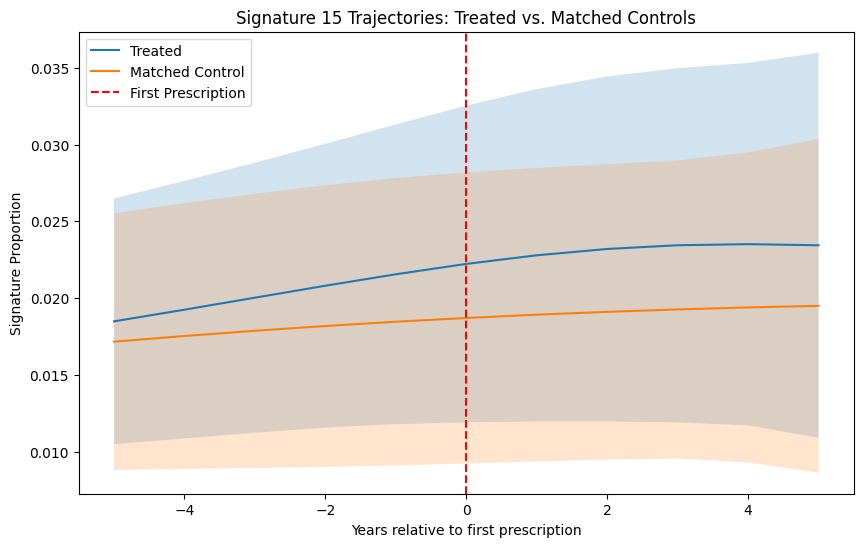

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
window = 5  # years before/after
desired_length = 2 * window + 1

trajectories_treated = []
trajectories_control = []
time_axes = []

for treated_idx, control_idx, eid in zip(treated_indices_final, untreated_indices_final, treated_eids_list):
    t0 = treated_time_idx[eid]
    t_start = max(0, t0 - window)
    t_end = min(lambdas.shape[2], t0 + window + 1)
    traj_treated = lambdas[treated_idx, sig_idx, t_start:t_end]
    # For control, align to same age window
    yob_control = eid_to_yob.get(int(processed_ids[control_idx]), None)
    yob_treated = eid_to_yob.get(int(processed_ids[treated_idx]), None)
    if yob_control is None or yob_treated is None:
        continue
    age_t0 = t0 + yob_treated
    t0_control = age_t0 - yob_control
    t_start_c = int(max(0, t0_control - window))
    t_end_c = int(min(lambdas.shape[2], t0_control + window + 1))
    traj_control = lambdas[control_idx, sig_idx, t_start_c:t_end_c]
    # Only keep if both are the desired length
    if len(traj_treated) == desired_length and len(traj_control) == desired_length:
        trajectories_treated.append(traj_treated)
        trajectories_control.append(traj_control)
        time_axes.append(tuple(np.arange(t_start-t0, t_end-t0)))

# Convert to arrays
trajectories_treated = np.array(trajectories_treated)
trajectories_control = np.array(trajectories_control)

# Use the most common time axis (should be symmetric around 0)
if len(time_axes) > 0:
    time_axis = max(set(time_axes), key=time_axes.count)
    time_axis = np.array(time_axis)
else:
    time_axis = np.arange(-window, window+1)

# Calculate means and stds
mean_treated = trajectories_treated.mean(axis=0)
mean_control = trajectories_control.mean(axis=0)
std_treated = trajectories_treated.std(axis=0)
std_control = trajectories_control.std(axis=0)

# Plot
plt.figure(figsize=(10,6))
plt.plot(time_axis, mean_treated, label='Treated')
plt.fill_between(time_axis, mean_treated-std_treated, mean_treated+std_treated, alpha=0.2)
plt.plot(time_axis, mean_control, label='Matched Control')
plt.fill_between(time_axis, mean_control-std_control, mean_control+std_control, alpha=0.2)
plt.axvline(0, color='r', linestyle='--', label='First Prescription')
plt.xlabel('Years relative to first prescription')
plt.ylabel('Signature Proportion')
plt.legend()
plt.title(f'Signature {sig_idx} Trajectories: Treated vs. Matched Controls')
plt.show()

In [13]:
print("Treated signature at event time (first 10):", [traj[window] for traj in trajectories_treated[:10]])
print("Control signature at event time (first 10):", [traj[window] for traj in trajectories_control[:10]])
print("Difference at event time (first 10):", [traj[window] - ctrl[window] for traj, ctrl in zip(trajectories_treated[:10], trajectories_control[:10])])

Treated signature at event time (first 10): [np.float64(0.020833867291175416), np.float64(0.02437524425850357), np.float64(0.014833899712398525), np.float64(0.021423710961787547), np.float64(0.024723827553829594), np.float64(0.02138051148458753), np.float64(0.015819767086439073), np.float64(0.015982006363049136), np.float64(0.024824376623448607), np.float64(0.02098286566325899)]
Control signature at event time (first 10): [np.float64(0.021082628326540936), np.float64(0.017511075395494728), np.float64(0.010412087862560964), np.float64(0.012755953870526509), np.float64(0.019863768430051557), np.float64(0.012150972405170228), np.float64(0.015240249015845893), np.float64(0.01598196481439509), np.float64(0.019974725580135883), np.float64(0.018306662257998315)]
Difference at event time (first 10): [np.float64(-0.00024876103536551966), np.float64(0.006864168863008842), np.float64(0.004421811849837561), np.float64(0.008667757091261039), np.float64(0.004860059123778036), np.float64(0.0092295390

In [48]:
import numpy as np
from scipy.spatial.distance import cdist

window = 5  # Number of timepoints/years before treatment to use

def compute_mean_and_slope(trajs):
    # trajs: shape (n_samples, n_sigs, window)
    x = np.arange(window)
    means = trajs.mean(axis=2)  # shape: (n_samples, n_sigs)
    # Compute slope for each signature using linear regression (vectorized)
    x_centered = x - x.mean()
    slopes = np.sum(trajs * x_centered, axis=2) / np.sum(x_centered**2)
    # Concatenate mean and slope for each signature
    return np.concatenate([means, slopes], axis=1)  # shape: (n_samples, n_sigs*2)


In [62]:

treated_indices_final = []
untreated_indices_final = []
treated_eids_list = []


In [63]:

for t0, eids in t0_to_treated.items():
    batch_treated_indices = [np.where(processed_ids == eid)[0][0] for eid in eids]
    # Only use controls with enough pre-treatment history
    valid_untreated_indices = [uidx for uidx in untreated_indices if t0 < lambdas.shape[2] and t0-window >= 0]
    if not valid_untreated_indices:
        continue
    # Get pre-treatment trajectories
    treated_traj = lambdas[batch_treated_indices, :, t0-window:t0]  # (n_batch, n_sigs, window)
    untreated_traj = lambdas[valid_untreated_indices, :, t0-window:t0]  # (n_untreated, n_sigs, window)
    # Compute mean and slope
    # Example: Give more weight to slope in the distance metric
 # Compute mean and slope for both groups
    treated_stats_raw = compute_mean_and_slope(treated_traj)      # shape: (n_batch, n_sigs*2)
    untreated_stats_raw = compute_mean_and_slope(untreated_traj)  # shape: (n_untreated, n_sigs*2)

    # Apply weights: first half is mean, second half is slope
    n_sigs = treated_traj.shape[1]
    weight_mean = 1.0
    weight_slope = 5.0  # Increase to prioritize slope matching

    treated_stats = np.copy(treated_stats_raw)
    untreated_stats = np.copy(untreated_stats_raw)
    treated_stats[:, n_sigs:] *= weight_slope
    untreated_stats[:, n_sigs:] *= weight_slope

    # Now compute distances
    dists = cdist(treated_stats, untreated_stats)
    match_idxs = dists.argmin(axis=1)
    for i, treated_idx in enumerate(batch_treated_indices):
        control_idx = valid_untreated_indices[match_idxs[i]]
        treated_indices_final.append(treated_idx)
        untreated_indices_final.append(control_idx)
        treated_eids_list.append(eids[i])

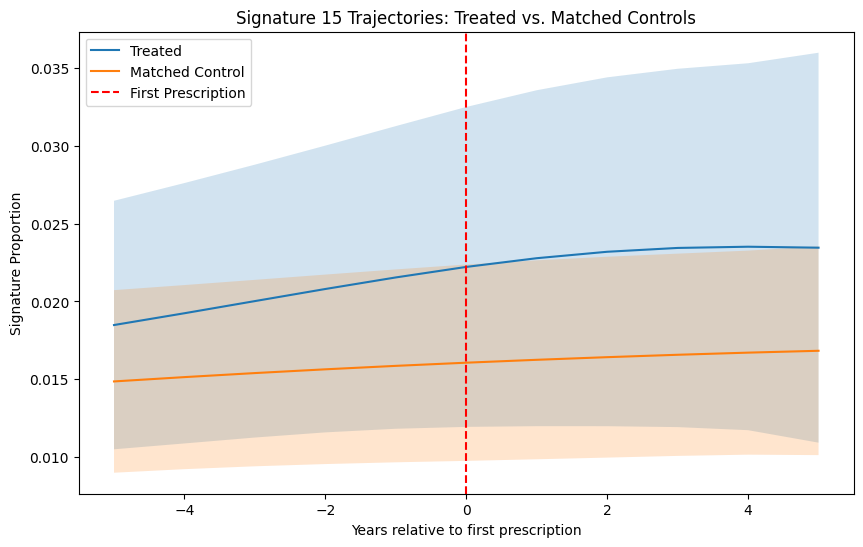

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
window = 5  # years before/after
desired_length = 2 * window + 1

trajectories_treated = []
trajectories_control = []
time_axes = []

for treated_idx, control_idx, eid in zip(treated_indices_final, untreated_indices_final, treated_eids_list):
    t0 = treated_time_idx[eid]
    t_start = max(0, t0 - window)
    t_end = min(lambdas.shape[2], t0 + window + 1)
    traj_treated = lambdas[treated_idx, sig_idx, t_start:t_end]
    # For control, align to same age window
    yob_control = eid_to_yob.get(int(processed_ids[control_idx]), None)
    yob_treated = eid_to_yob.get(int(processed_ids[treated_idx]), None)
    if yob_control is None or yob_treated is None:
        continue
    age_t0 = t0 + yob_treated
    t0_control = age_t0 - yob_control
    t_start_c = int(max(0, t0_control - window))
    t_end_c = int(min(lambdas.shape[2], t0_control + window + 1))
    traj_control = lambdas[control_idx, sig_idx, t_start_c:t_end_c]
    # Only keep if both are the desired length
    if len(traj_treated) == desired_length and len(traj_control) == desired_length:
        trajectories_treated.append(traj_treated)
        trajectories_control.append(traj_control)
        time_axes.append(tuple(np.arange(t_start-t0, t_end-t0)))

# Convert to arrays
trajectories_treated = np.array(trajectories_treated)
trajectories_control = np.array(trajectories_control)

# Use the most common time axis (should be symmetric around 0)
if len(time_axes) > 0:
    time_axis = max(set(time_axes), key=time_axes.count)
    time_axis = np.array(time_axis)
else:
    time_axis = np.arange(-window, window+1)

# Calculate means and stds
mean_treated = trajectories_treated.mean(axis=0)
mean_control = trajectories_control.mean(axis=0)
std_treated = trajectories_treated.std(axis=0)
std_control = trajectories_control.std(axis=0)

# Plot
plt.figure(figsize=(10,6))
plt.plot(time_axis, mean_treated, label='Treated')
plt.fill_between(time_axis, mean_treated-std_treated, mean_treated+std_treated, alpha=0.2)
plt.plot(time_axis, mean_control, label='Matched Control')
plt.fill_between(time_axis, mean_control-std_control, mean_control+std_control, alpha=0.2)
plt.axvline(0, color='r', linestyle='--', label='First Prescription')
plt.xlabel('Years relative to first prescription')
plt.ylabel('Signature Proportion')
plt.legend()
plt.title(f'Signature {sig_idx} Trajectories: Treated vs. Matched Controls')
plt.show()

In [61]:
# Check pre-treatment means and slopes
pre_treated = trajectories_treated[:, :window]  # t < 0
pre_control = trajectories_control[:, :window]

mean_treated = pre_treated.mean()
mean_control = pre_control.mean()
slope_treated = np.polyfit(np.arange(-window, 0), pre_treated.mean(axis=0), 1)[0]
slope_control = np.polyfit(np.arange(-window, 0), pre_control.mean(axis=0), 1)[0]

print(f"Pre-treatment mean (treated): {mean_treated:.4f}")
print(f"Pre-treatment mean (control): {mean_control:.4f}")
print(f"Pre-treatment slope (treated): {slope_treated:.4f}")
print(f"Pre-treatment slope (control): {slope_control:.4f}")

Pre-treatment mean (treated): 0.0200
Pre-treatment mean (control): 0.0154
Pre-treatment slope (treated): 0.0008
Pre-treatment slope (control): 0.0003


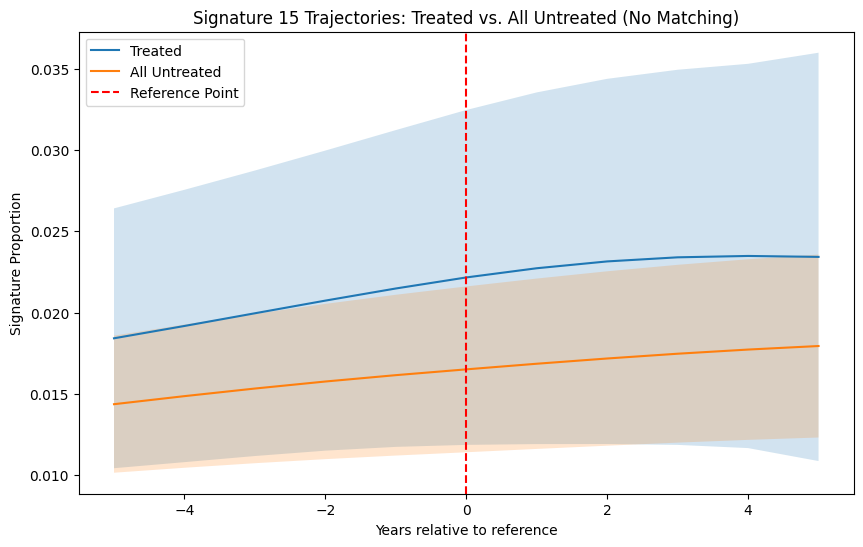

In [32]:
## without matching

import numpy as np
import matplotlib.pyplot as plt

window = 5  # years before/after
desired_length = 2 * window + 1

trajectories_treated = []
trajectories_untreated = []
time_axes = []

# For treated
for eid in treated_time_idx.keys():
    t0 = treated_time_idx[eid]
    idx = np.where(processed_ids == eid)[0][0]
    t_start = max(0, t0 - window)
    t_end = min(lambdas.shape[2], t0 + window + 1)
    traj = lambdas[idx, sig_idx, t_start:t_end]
    if len(traj) == desired_length:
        trajectories_treated.append(traj)
        time_axes.append(tuple(np.arange(t_start-t0, t_end-t0)))

# For untreated: pick a random t0 for each untreated individual, or use a fixed t0 (e.g., middle of time axis)
for idx in untreated_indices:
    # Option 1: Use a fixed t0 (e.g., middle of time axis)
    t0 = lambdas.shape[2] // 2
    t_start = max(0, t0 - window)
    t_end = min(lambdas.shape[2], t0 + window + 1)
    traj = lambdas[idx, sig_idx, t_start:t_end]
    if len(traj) == desired_length:
        trajectories_untreated.append(traj)

# Convert to arrays
trajectories_treated = np.array(trajectories_treated)
trajectories_untreated = np.array(trajectories_untreated)

# Use the most common time axis (should be symmetric around 0)
if len(time_axes) > 0:
    time_axis = max(set(time_axes), key=time_axes.count)
    time_axis = np.array(time_axis)
else:
    time_axis = np.arange(-window, window+1)

# Calculate means and stds
mean_treated = trajectories_treated.mean(axis=0)
std_treated = trajectories_treated.std(axis=0)
mean_untreated = trajectories_untreated.mean(axis=0)
std_untreated = trajectories_untreated.std(axis=0)

# Plot
plt.figure(figsize=(10,6))
plt.plot(time_axis, mean_treated, label='Treated')
plt.fill_between(time_axis, mean_treated-std_treated, mean_treated+std_treated, alpha=0.2)
plt.plot(time_axis, mean_untreated, label='All Untreated')
plt.fill_between(time_axis, mean_untreated-std_untreated, mean_untreated+std_untreated, alpha=0.2)
plt.axvline(0, color='r', linestyle='--', label='Reference Point')
plt.xlabel('Years relative to reference')
plt.ylabel('Signature Proportion')
plt.legend()
plt.title(f'Signature {sig_idx} Trajectories: Treated vs. All Untreated (No Matching)')
plt.show()

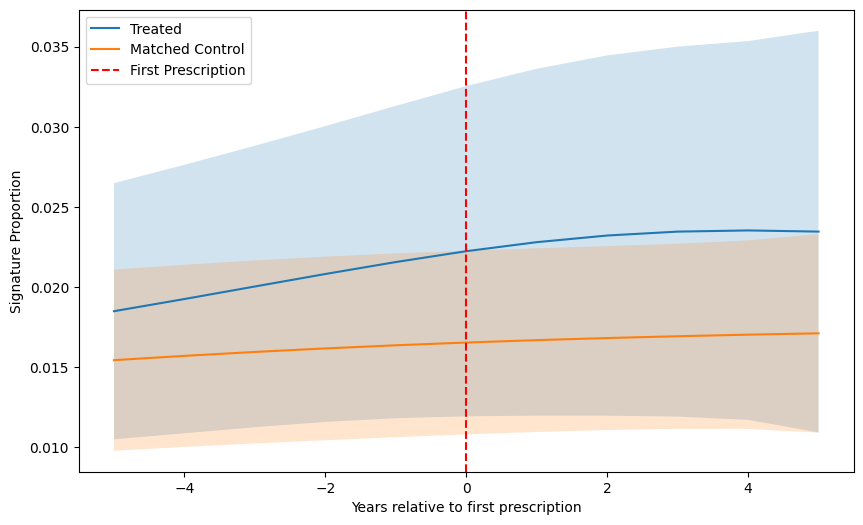

In [59]:

# 7. For each treated, match to an untreated with similar baseline signature


window = 5  # years before/after
desired_length = 2 * window + 1

trajectories_treated = []
trajectories_control = []
time_axes = []

for treated_idx, control_idx, eid in matched_pairs:
    t0 = treated_time_idx[eid]
    t_start = max(0, t0 - window)
    t_end = min(lambdas.shape[2], t0 + window + 1)
    traj_treated = lambdas[treated_idx, sig_idx, t_start:t_end]
    yob_control = eid_to_yob.get(int(processed_ids[control_idx]), None)
    yob_treated = eid_to_yob.get(int(processed_ids[treated_idx]), None)
    if yob_control is None or yob_treated is None:
        continue
    age_t0 = t0 + yob_treated
    t0_control = age_t0 - yob_control
    t_start_c = int(max(0, t0_control - window))
    t_end_c = int(min(lambdas.shape[2], t0_control + window + 1))
    traj_control = lambdas[control_idx, sig_idx, t_start_c:t_end_c]
    # Only keep if both are the desired length
    if len(traj_treated) == desired_length and len(traj_control) == desired_length:
        trajectories_treated.append(traj_treated)
        trajectories_control.append(traj_control)
        time_axes.append(tuple(np.arange(t_start-t0, t_end-t0)))

# 9. Aggregate and plot
trajectories_treated = np.array(trajectories_treated)
trajectories_control = np.array(trajectories_control)
# Use the most common time axis (should be symmetric around 0)
if len(time_axes) > 0:
    time_axis = max(set(tuple(x) for x in time_axes), key=time_axes.count)
    time_axis = np.array(time_axis)
else:
    time_axis = np.arange(-window, window+1)

mean_treated = trajectories_treated.mean(axis=0)
mean_control = trajectories_control.mean(axis=0)
std_treated = trajectories_treated.std(axis=0)
std_control = trajectories_control.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(time_axis, mean_treated, label='Treated')
plt.fill_between(time_axis, mean_treated-std_treated, mean_treated+std_treated, alpha=0.2)
plt.plot(time_axis, mean_control, label='Matched Control')
plt.fill_between(time_axis, mean_control-std_control, mean_control+std_control, alpha=0.2)
plt.axvline(0, color='r', linestyle='--', label='First Prescription')
plt.xlabel('Years relative to first prescription')
plt.ylabel('Signature Proportion')
plt.legend()
plt.show()

# Example 2: Simulate an intervention
# Let's say we want to reduce the effect of signature 0 by 30%

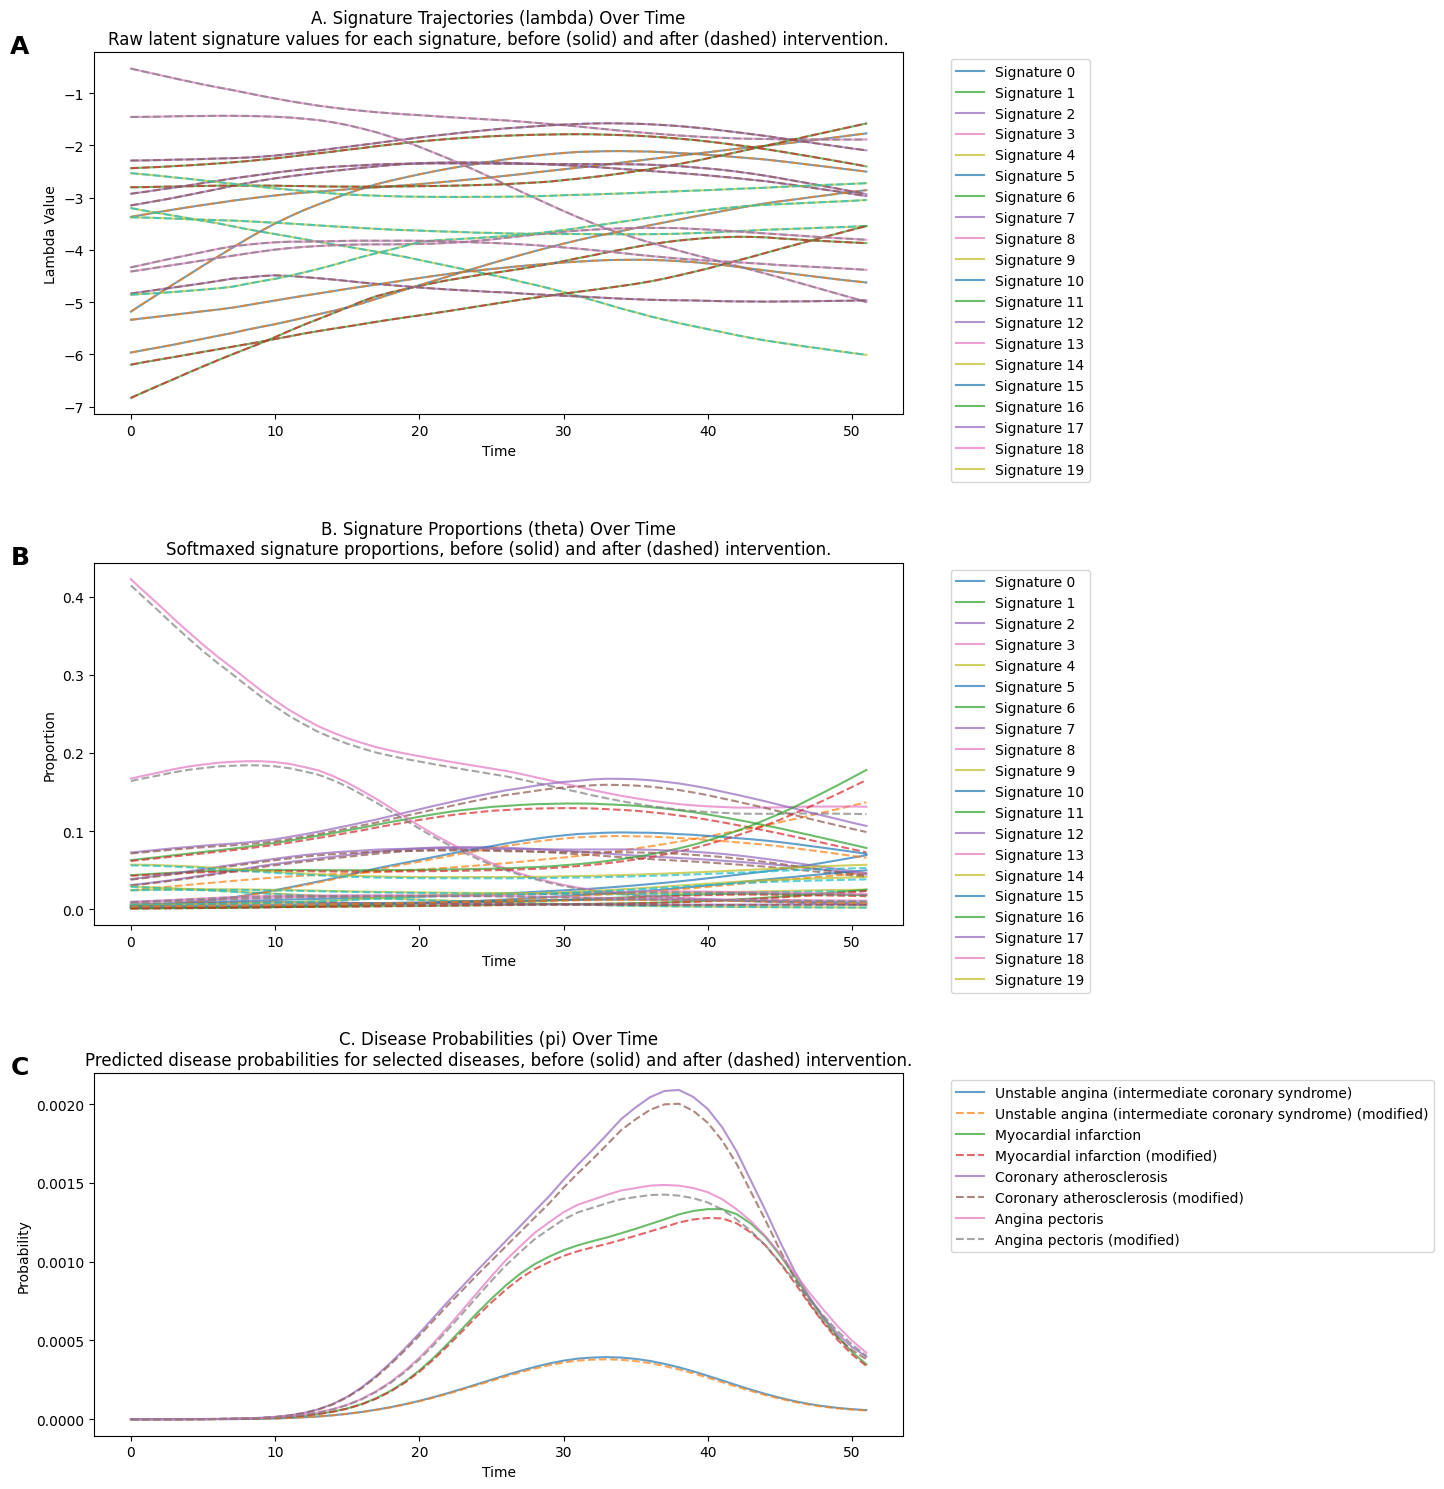

In [10]:

intervention_data = twin_manager.simulate_intervention(
    twin_data,
    intervention_type='reduce',
    target_signature=0,
    effect_size=0.3
)

# Plot original vs intervention trajectories
twin_manager.plot_twin_trajectories(
    twin_data,
    modified_data=intervention_data,
    selected_diseases=[111,112,114,113]
)



# Example 3: Compare two different genetic profiles
# Create another twin with different genetic profile


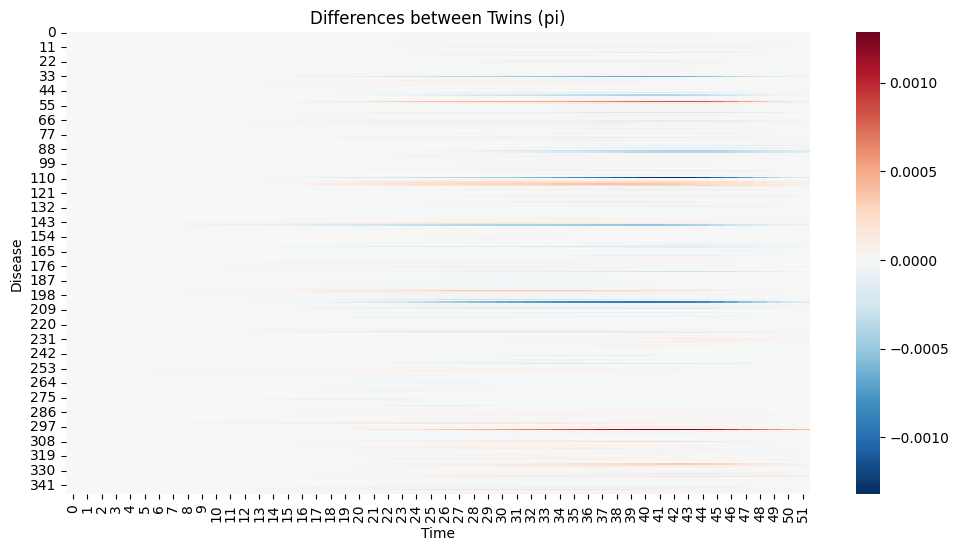


Mean differences in disease probabilities:
Disease 0: 0.0000
Disease 1: 0.0000
Disease 2: 0.0000
Disease 3: 0.0000
Disease 4: 0.0000
Disease 5: 0.0000
Disease 6: 0.0000
Disease 7: 0.0000
Disease 8: 0.0000
Disease 9: 0.0000
Disease 10: -0.0000
Disease 11: -0.0000
Disease 12: -0.0000
Disease 13: 0.0000
Disease 14: 0.0000
Disease 15: 0.0001
Disease 16: 0.0000
Disease 17: 0.0000
Disease 18: -0.0000
Disease 19: -0.0000
Disease 20: -0.0000
Disease 21: -0.0000
Disease 22: 0.0000
Disease 23: -0.0000
Disease 24: 0.0000
Disease 25: 0.0000
Disease 26: 0.0000
Disease 27: 0.0000
Disease 28: 0.0000
Disease 29: 0.0000
Disease 30: 0.0000
Disease 31: 0.0000
Disease 32: 0.0000
Disease 33: -0.0003
Disease 34: 0.0000
Disease 35: -0.0000
Disease 36: 0.0000
Disease 37: 0.0000
Disease 38: 0.0000
Disease 39: 0.0000
Disease 40: -0.0000
Disease 41: -0.0000
Disease 42: 0.0000
Disease 43: 0.0000
Disease 44: 0.0000
Disease 45: -0.0001
Disease 46: -0.0000
Disease 47: -0.0001
Disease 48: -0.0000
Disease 49: -0.0000

In [11]:

another_genetic_profile = np.random.randn(model.P)
twin2_data = twin_manager.create_twin(another_genetic_profile)

# Compare the twins
comparison = twin_manager.compare_twins(twin_data, twin2_data, metric='pi')
print("\nMean differences in disease probabilities:")
for d, diff in enumerate(comparison['mean_difference']):
    print(f"Disease {d}: {diff:.4f}")


In [18]:
model.clusters[111:115]

array([5, 5, 5, 5], dtype=int32)

/Users/sarahurbut/aladynoulli2/pyScripts/digital_twin.py:83: RuntimeWarning: divide by zero encountered in matmul
  eps = L @ np.random.randn(self.T)
/Users/sarahurbut/aladynoulli2/pyScripts/digital_twin.py:83: RuntimeWarning: overflow encountered in matmul
  eps = L @ np.random.randn(self.T)
/Users/sarahurbut/aladynoulli2/pyScripts/digital_twin.py:83: RuntimeWarning: invalid value encountered in matmul
  eps = L @ np.random.randn(self.T)
/Users/sarahurbut/aladynoulli2/pyScripts/digital_twin.py:90: RuntimeWarning: divide by zero encountered in matmul
  eps = L @ np.random.randn(self.T)
/Users/sarahurbut/aladynoulli2/pyScripts/digital_twin.py:90: RuntimeWarning: overflow encountered in matmul
  eps = L @ np.random.randn(self.T)
/Users/sarahurbut/aladynoulli2/pyScripts/digital_twin.py:90: RuntimeWarning: invalid value encountered in matmul
  eps = L @ np.random.randn(self.T)


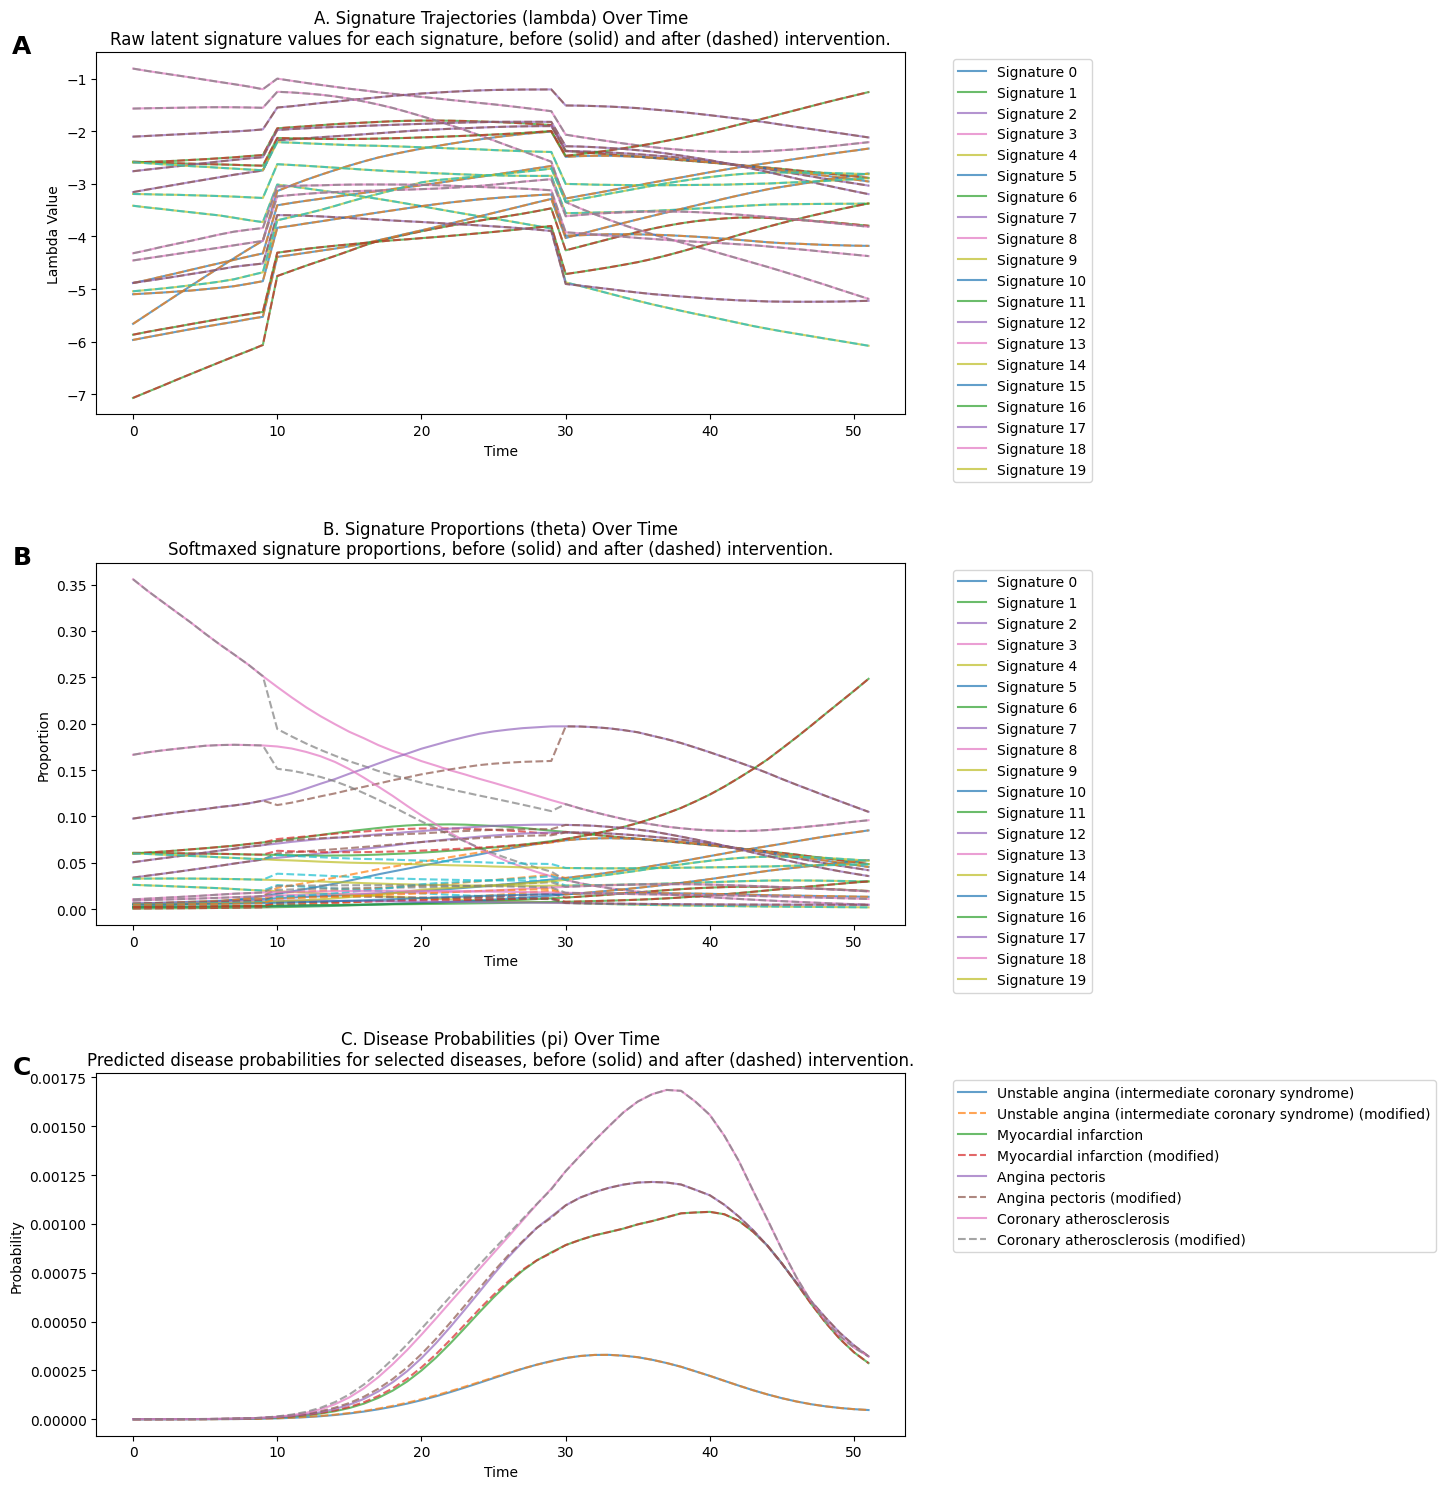

In [12]:
# Example 4: Simulate multiple interventions
# Create a twin with high cardiovascular risk
high_cv_risk_profile = np.random.randn(model.P)
high_cv_risk_profile[0:5] += 2  # Increase some genetic factors
cv_twin = twin_manager.create_twin(high_cv_risk_profile)

# Simulate lifestyle intervention (reducing multiple signatures)
lifestyle_intervention = twin_manager.simulate_intervention(
    cv_twin,
    intervention_type='reduce',
    target_signature=None,  # Affects all signatures
    effect_size=0.2,
    start_time=10,  # Start at time 10
    end_time=30     # End at time 30
)

# Plot the effect of lifestyle intervention
twin_manager.plot_twin_trajectories(
    cv_twin,
    modified_data=lifestyle_intervention,
    selected_diseases=[111,112,113,114]
) 

Plotting diseases 111-115 with intervention on signature 5 (20% reduction)...


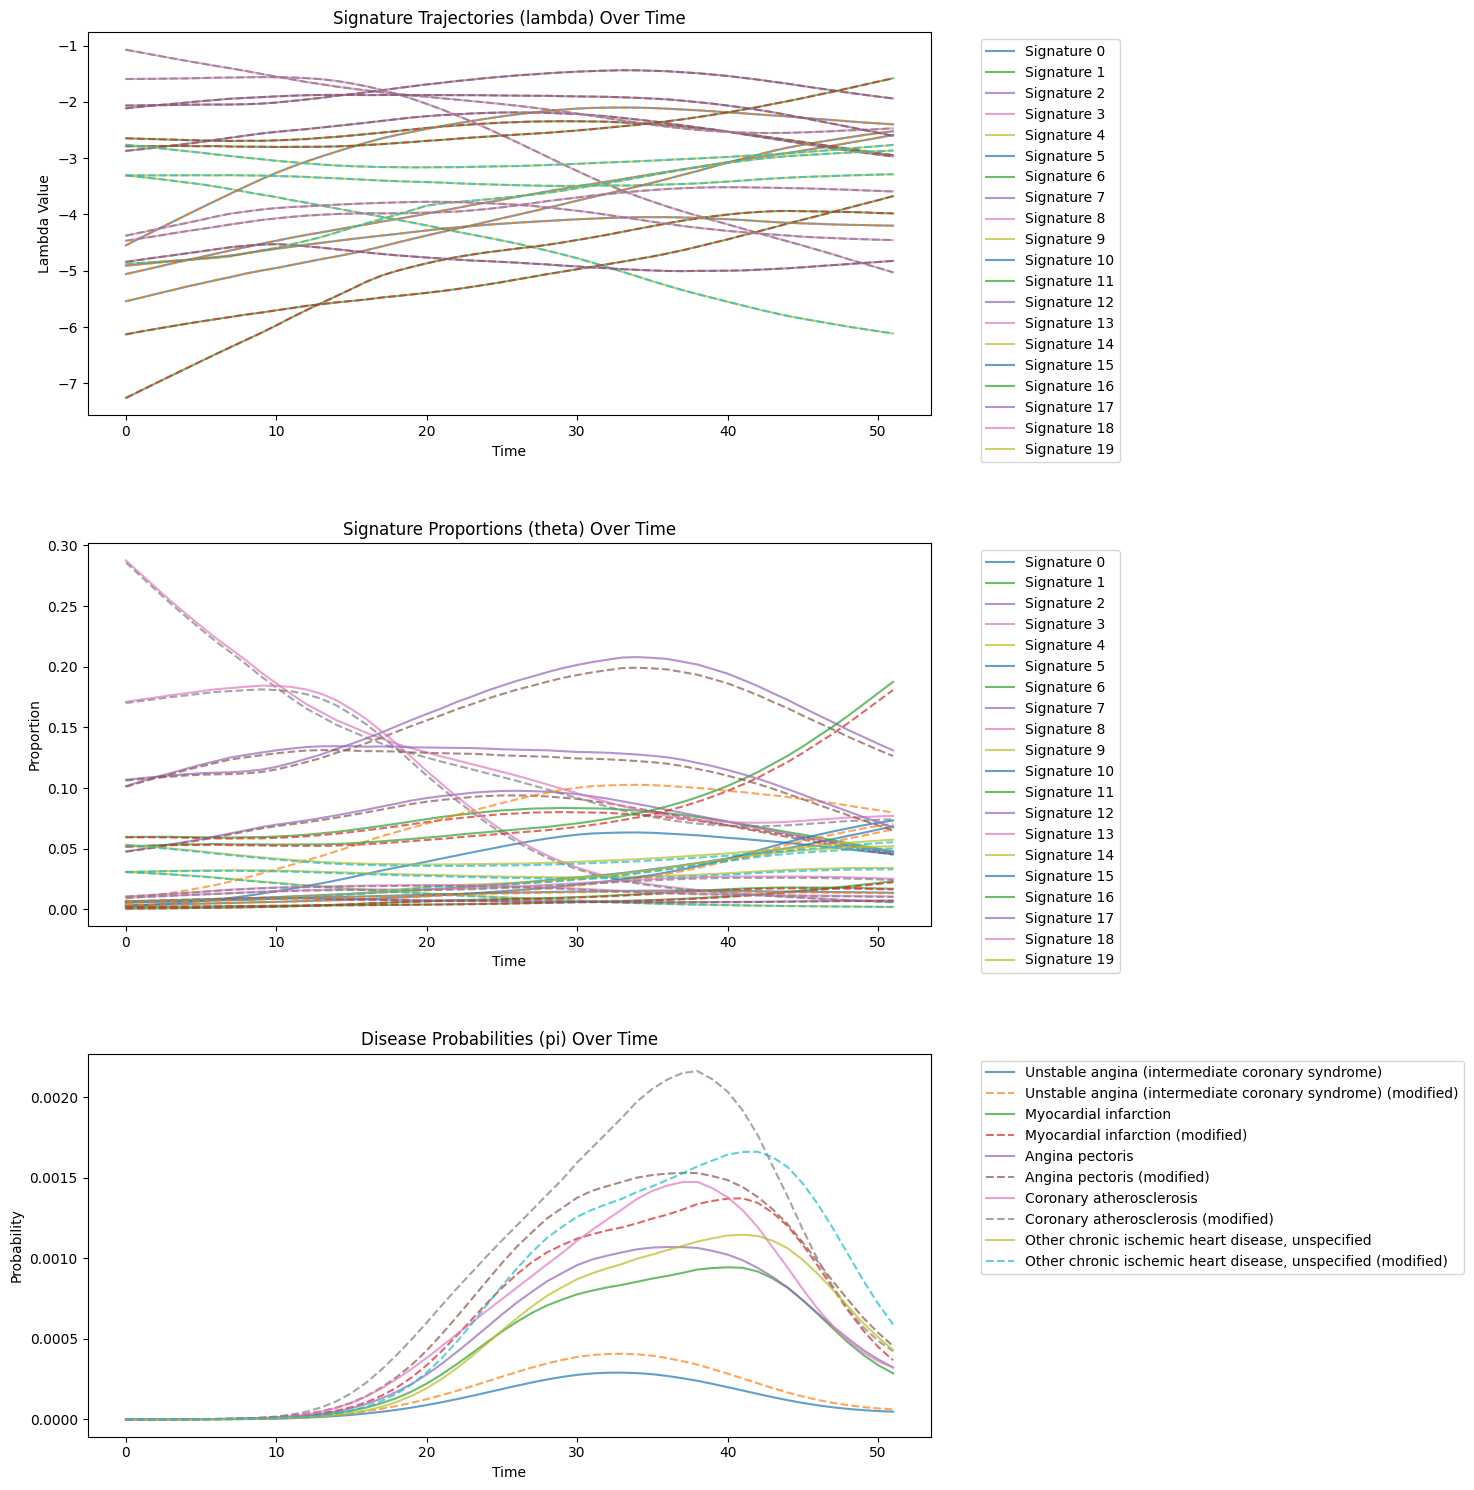

In [16]:
# Example: Plot diseases 111-115 and simulate an intervention reducing signature 5 by 20%
selected_diseases = [111, 112, 113, 114, 115]

# Create a digital twin for a random genetic profile
random_genetic_profile = np.random.randn(model.P)
twin_data = twin_manager.create_twin(random_genetic_profile)

# Simulate intervention: reduce signature 5 by 20%
modified_data = twin_manager.simulate_intervention(
    twin_data,
    intervention_type='reduce',
    target_signature=5,
    effect_size=0.2
)

# Plot the selected diseases before and after intervention
print("Plotting diseases 111-115 with intervention on signature 5 (20% reduction)...")
twin_manager.plot_twin_trajectories(
    twin_data,
    modified_data=modified_data,
    selected_diseases=selected_diseases
) 

In [13]:
import pandas as pd

# Load your script data (convert from RDS to CSV or use pyreadr if needed)
script = pd.read_csv('prescription.csv')  # or use pyreadr to read RDS


In [29]:

g = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/G_matrix.pt')

import numpy as np

# Load patient IDs
patient_ids = np.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/patient_ids.npy')
print(patient_ids.shape)
print(patient_ids[:10])  # Show the first 10 IDs



(407878,)
['1000015' '1000023' '1000037' '1000042' '1000059' '1000061' '1000078'
 '1000086' '1000107' '1000113']


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_39842/2727691544.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load('/Users/sarahurbut/Library/Clo

In [133]:
first_eid = str(script['eid'].values[10]) 

In [134]:
idx = np.where(patient_ids == first_eid)[0]
if len(idx) == 0:
    print(f"eid {first_eid} not found in the first 10K batch!")
else:
    idx = idx[0]
    print(f"Index of eid {first_eid} in patient_ids: {idx}")
genetic_profile_for_eid = g[idx].numpy() if hasattr(g[idx], 'numpy') else g[idx]
first_eid = int(first_eid)
person_script = script[script['eid'] == first_eid]

Index of eid 1000375 in patient_ids: 27


In [136]:
type(first_eid)

int

In [137]:
import pandas as pd


cov = pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox/for_regenie/ukbb_covariates_400k.txt', sep=' ')
# Make sure columns are named
cov.columns = cov.columns.str.strip()  # Remove any leading/trailing spaces


# Let's assume columns: ['identifier', 'sex', 'year_of_birth', ...]
cov = cov.rename(columns={cov.columns[0]: 'eid', cov.columns[2]: 'year_of_birth'})


In [138]:

# Suppose you have a digital twin for this eid
drug_class_to_signature = {
    'statins': 5,
    'anti_hypertensives': 0,
    'diabetes': 15,
    'antipsychotics': 7, 'steroids': 16


    # etc.
}


In [139]:
cov.head()

,eid,sex,year_of_birth,enrollment,PC1,PC2,PC3,PC4,PC5,PC6,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,1000015,1,1938,2008-07-23,-12.02340,3.25100,1.224590,4.776840,2.31802,2.445040,...,2.023600,1.641170,0.161407,-2.293140,1.08346,-0.717937,-0.627368,-0.082943,3.601450,4.934770
1,1000023,1,1963,2008-09-11,-14.07040,2.83809,-1.709870,-0.782455,-7.93571,-2.176480,...,5.740360,-1.726000,-1.566490,0.139009,1.01087,2.152510,-0.819635,3.028260,2.686200,-0.237987
2,1000037,0,1939,2009-01-22,-15.00630,4.03881,-1.711670,6.200160,-2.77040,0.809991,...,-4.519320,4.027890,1.865970,4.176570,2.07576,-0.896987,1.993830,2.332760,-5.014460,3.937040
3,1000042,1,1942,2009-11-13,-12.08720,6.29019,-1.486040,-3.426860,-5.35913,-0.146506,...,-2.000660,-0.999069,-0.624147,-1.642880,-3.59239,-5.715930,5.212110,-0.692624,3.301050,-2.631200
4,1000059,0,1954,2009-05-20,-9.58886,3.77243,0.274298,-1.357730,1.91795,-1.627780,...,0.691295,-0.825097,0.062332,-3.160660,-1.96172,2.282220,0.892687,-0.234448,-0.609894,-0.555967


In [140]:
person_script.head()

,eid,from,to,category,type
10,1000375,1999-09-01,1999-11-29,anti_hypertensives,any
11,1000375,2000-03-07,2000-09-24,anti_hypertensives,any
12,1000375,2000-09-26,2001-02-12,anti_hypertensives,any
13,1000375,2001-04-30,2001-09-22,anti_hypertensives,any
14,1000375,2001-10-25,2003-01-04,anti_hypertensives,any


In [148]:

def date_to_time_index(date, year_of_birth, min_age=30):
    year = pd.to_datetime(date).year
    age = year - int(year_of_birth)
    return age - 30  # 
twin_data = twin_manager.create_twin(genetic_profile_for_eid)
person_script = script[script['eid'] == int(first_eid)]  # ensure int if needed
year_of_birth = cov.loc[cov['eid'] == int(first_eid), 'year_of_birth'].values[0]


/Users/sarahurbut/aladynoulli2/pyScripts/digital_twin.py:83: RuntimeWarning: divide by zero encountered in matmul
  eps = L @ np.random.randn(self.T)
/Users/sarahurbut/aladynoulli2/pyScripts/digital_twin.py:83: RuntimeWarning: overflow encountered in matmul
  eps = L @ np.random.randn(self.T)
/Users/sarahurbut/aladynoulli2/pyScripts/digital_twin.py:83: RuntimeWarning: invalid value encountered in matmul
  eps = L @ np.random.randn(self.T)
/Users/sarahurbut/aladynoulli2/pyScripts/digital_twin.py:90: RuntimeWarning: divide by zero encountered in matmul
  eps = L @ np.random.randn(self.T)
/Users/sarahurbut/aladynoulli2/pyScripts/digital_twin.py:90: RuntimeWarning: overflow encountered in matmul
  eps = L @ np.random.randn(self.T)
/Users/sarahurbut/aladynoulli2/pyScripts/digital_twin.py:90: RuntimeWarning: invalid value encountered in matmul
  eps = L @ np.random.randn(self.T)


In [149]:
row = cov.loc[cov['eid'] == int(first_eid)]
if row.empty:
    print(f"eid {first_eid} not found in covariate file")
else:
    year_of_birth = int(row['year_of_birth'].values[0])
    print(year_of_birth)

1940


In [150]:
row = cov.loc[cov['eid'] == int(first_eid)]
if row.empty:
    print(f"eid {first_eid} not found in covariate file")
else:
    year_of_birth = int(row['year_of_birth'].values[0])
    print(year_of_birth)

1940


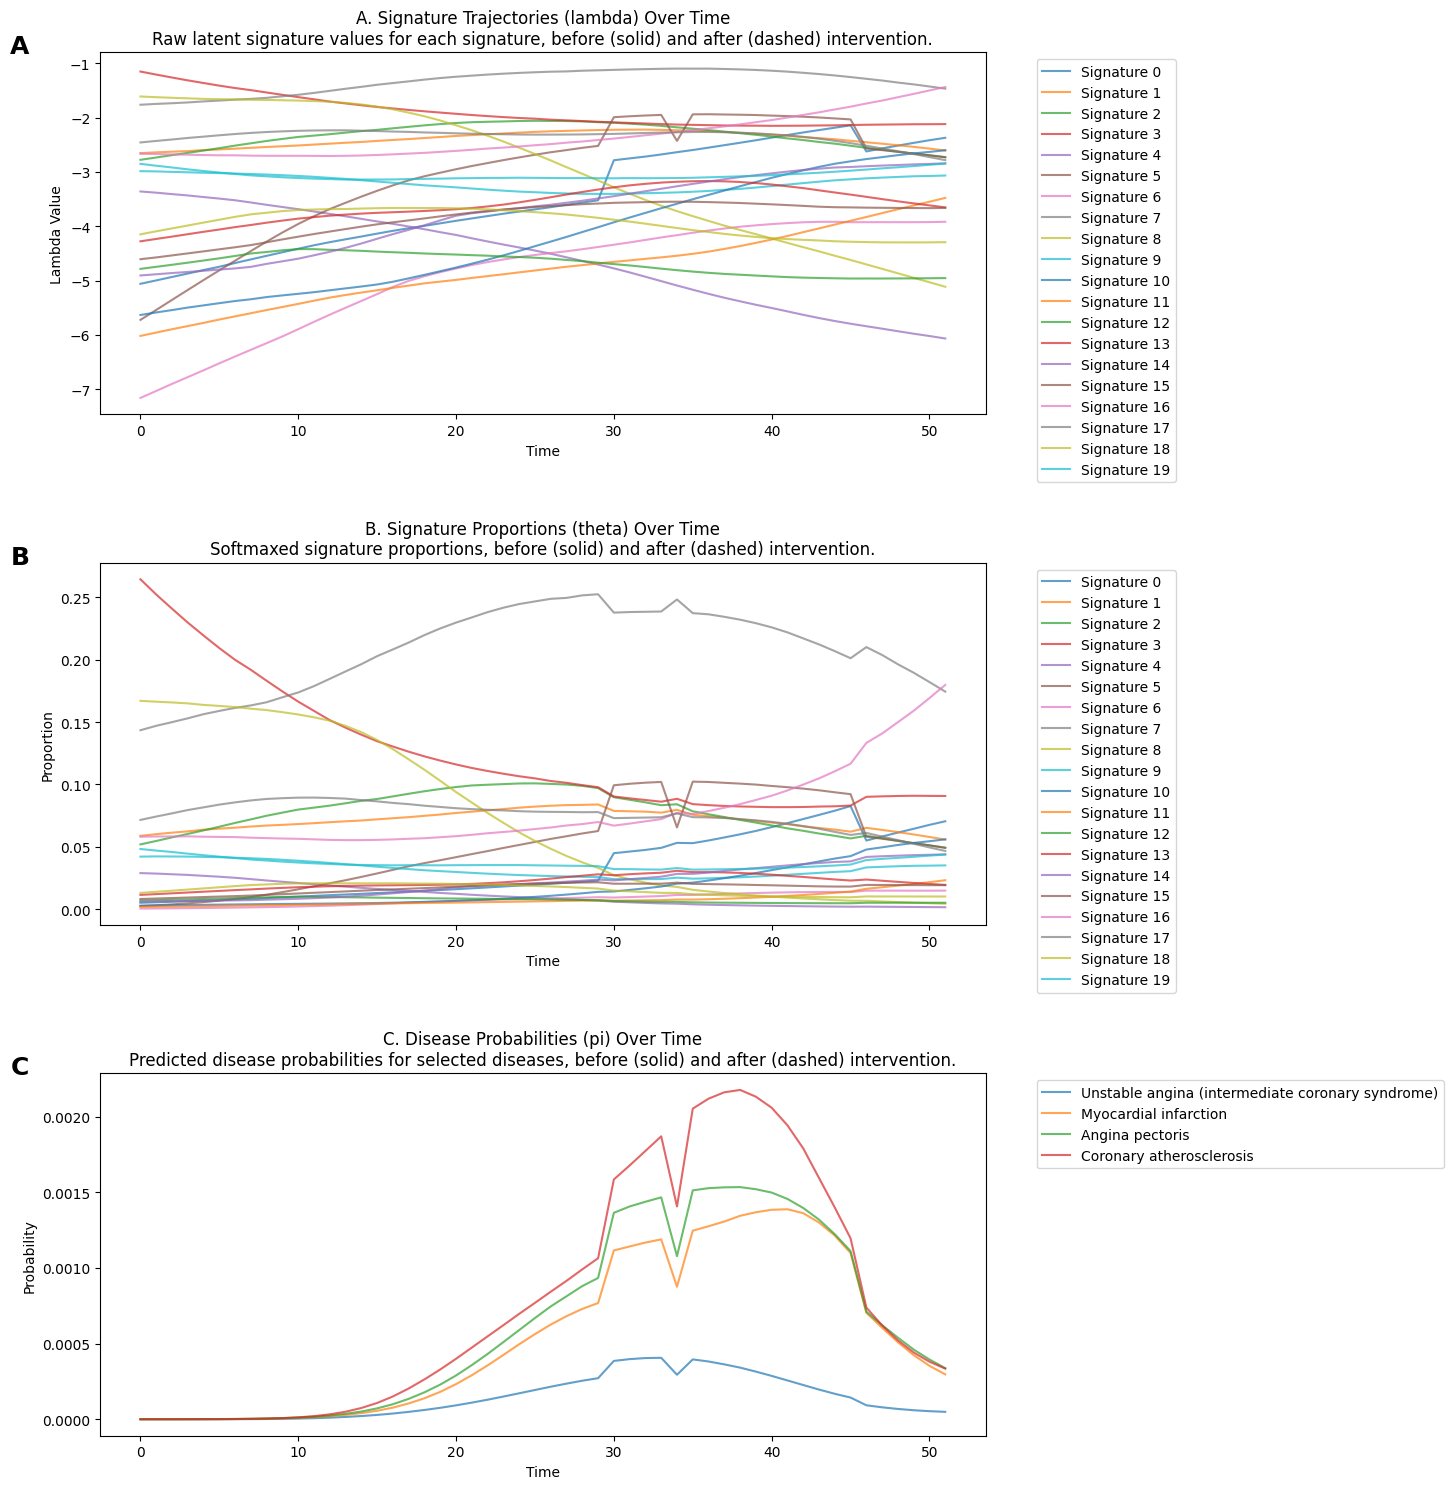

In [151]:

for _, row in person_script.iterrows():
    drug_class = row['category']
    if drug_class not in drug_class_to_signature:
        print(f"Drug class {drug_class} not mapped to a signature, skipping.")
        continue
    signature_idx = drug_class_to_signature[drug_class]
    start_date = row['from']
    end_date = row['to']
    start_time = date_to_time_index(start_date, year_of_birth)
    end_time = date_to_time_index(end_date, year_of_birth)
    # Clamp to model time range
    start_time = max(0, min(start_time, twin_data['lambda'].shape[1]-1))
    end_time = max(0, min(end_time, twin_data['lambda'].shape[1]))
    twin_data = twin_manager.simulate_intervention(
        twin_data,
        intervention_type='reduce',
        target_signature=signature_idx,
        effect_size=0.2,
        start_time=start_time,
        end_time=end_time
    )

# Plot or analyze the effect
twin_manager.plot_twin_trajectories(twin_data, selected_diseases=[111,112,113,114])

In [152]:

# Suppose you have a digital twin for this eid
drug_class_to_signature = {
    'statins': 5,
    'anti_hypertensives': 0,
    'diabetes': 15,
    'antipsychotics': 7, 'steroids': 16


    # etc.
}


In [6]:
import os
import glob
import numpy as np
import torch
import re



# List all output directories and sort them properly by their index numbers
def sort_by_index(dir_name):
    # Extract just the start number from directory name
    # e.g., from 'output_10000_20000_20241225_062028' get '10000'
    match = re.search(r'output_(\d+)_\d+', dir_name)
    if match:
        return int(match.group(1))
    return 0

base_dir='/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results'

# Test the sorting
output_dirs = sorted(glob.glob(os.path.join(base_dir, 'output_*')), key=sort_by_index)

# Print first few directories to verify sorting
print("Verifying directory sorting:")
for dir_path in output_dirs[:5]:
    print(dir_path)


# Initialize the full array
all_lambdas = np.zeros((400000, 21, 52))  # [n_individuals, n_signatures, n_timepoints]

# Keep track of processed indices
processed_ranges = []

# Load and combine lambda from each model
current_idx = 0
for dir_path in output_dirs:
    model_path = os.path.join(dir_path, 'model.pt')
    try:
        # Extract batch range from directory name
        batch_range = re.findall(r'output_(\d+)_(\d+)', os.path.basename(dir_path))
        if batch_range:
            start_idx, end_idx = map(int, batch_range[0])
            print(f"\nProcessing batch {start_idx}-{end_idx}")
            
            # Verify this matches our current_idx
            if current_idx != start_idx:
                print(f"WARNING: Index mismatch! current_idx={current_idx}, but batch starts at {start_idx}")
        
        # Load the saved model
        checkpoint = torch.load(model_path)
        
        # Extract lambda
        if 'model_state_dict' in checkpoint:
            lambda_values = checkpoint['model_state_dict']['lambda_']
        else:
            lambda_values = checkpoint['lambda_']
            
        # Convert to numpy if it's a tensor
        if torch.is_tensor(lambda_values):
            lambda_values = lambda_values.detach().cpu().numpy()
        
        # Get batch size
        batch_size = lambda_values.shape[0]
        
        # Add to the full array
        all_lambdas[current_idx:current_idx + batch_size] = lambda_values
        
        # Store processed range
        processed_ranges.append((current_idx, current_idx + batch_size))
        
        print(f"Loaded lambda from {dir_path}")
        print(f"Batch size: {batch_size}")
        print(f"Current index range: {current_idx} to {current_idx + batch_size}")
        
        current_idx += batch_size
        
    except Exception as e:
        print(f"Error loading from {dir_path}: {e}")

# Verify no gaps or overlaps in processed ranges
processed_ranges.sort()
for i in range(len(processed_ranges)-1):
    if processed_ranges[i][1] != processed_ranges[i+1][0]:
        print(f"WARNING: Gap or overlap between batches! {processed_ranges[i]} and {processed_ranges[i+1]}")

# Save the combined lambdas
#np.save('all_lambdas_combined.npy', all_lambdas)

# Print final verification
print("\nFinal verification:")
print("Shape of all_lambdas:", all_lambdas.shape)
print("Total individuals processed:", current_idx)
print("Processed ranges:", processed_ranges)

# Load patient IDs and verify length matches
patient_ids = np.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/patient_ids.npy')
# Verify dimensions
print("Total available patient IDs:", len(patient_ids))  # Should be 407,878
print("Processed lambda shape:", all_lambdas.shape)      # Should be (400000, 20, 52)

# Create mapping of processed IDs
processed_ids = patient_ids[:400000]  # Get just the first 400K IDs we processed
print("\nVerification of processed IDs:")
print("Number of processed IDs:", len(processed_ids))
print("First few IDs:", processed_ids[:5])
print("Last few IDs:", processed_ids[-5:])

# Save the processed IDs mapping
np.save('processed_patient_ids.npy', processed_ids)

# Print some stats about unprocessed patients
unprocessed_ids = patient_ids[400000:]
print("\nUnprocessed patients:")
print("Number of unprocessed IDs:", len(unprocessed_ids))
print("First few unprocessed IDs:", unprocessed_ids[:5])

Verifying directory sorting:
/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_0_10000
/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_10000_20000
/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_20000_30000
/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_30000_40000
/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_40000_50000

Processing batch 0-10000
Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_0_10000
Batch size: 10000
Current index range: 0 to 10000

Processing batch 10000-20000


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_34368/3681310233.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_10000_20000
Batch size: 10000
Current index range: 10000 to 20000

Processing batch 20000-30000
Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_20000_30000
Batch size: 10000
Current index range: 20000 to 30000

Processing batch 30000-40000
Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_30000_40000
Batch size: 10000
Current index range: 30000 to 40000

Processing batch 40000-50000
Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_40000_50000
Batch size: 10000
Current index range: 40000 to 50000

Processing batch 50000-60000
Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_50000_60000
Batch size: 10000
Current index range: 50000 to 60000

Processing batch 60000-70000
Loaded lambda from /Users/sarahurbut/Lib

In [155]:
import os
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.special import expit

# --- CONFIGURATION ---
batch_size = 10000
results_dir = '/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results'
patient_ids = np.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/patient_ids.npy')

# Load your script data (convert from RDS to CSV or use pyreadr if needed)
script = pd.read_csv('prescription.csv')  #
model_phi = model.phi
disease_names = model.disease_names

# --- FUNCTION TO LOAD LAMBDA FOR AN EID ---
def load_lambda_for_eid(eid, patient_ids, batch_size, results_dir):
    idx = np.where(patient_ids == eid)[0][0]
    batch_start = (idx // batch_size) * batch_size
    batch_end = batch_start + batch_size
    batch_dir = os.path.join(results_dir, f'output_{batch_start}_{batch_end}')
    model_path = os.path.join(batch_dir, 'model.pt')
    checkpoint = torch.load(model_path)
    lambda_batch = checkpoint['model_state_dict']['lambda_'].detach().cpu().numpy()
    idx_in_batch = idx - batch_start
    return lambda_batch[idx_in_batch]

# --- 1. Compute baseline theta for all individuals ---
def compute_theta(lambda_vec):
    exp_lambda = np.exp(lambda_vec)
    return exp_lambda / np.sum(exp_lambda)

all_eids = patient_ids[:400000]  # or whatever range you have
all_thetas = []
for eid in all_eids:
    lambda_individual = load_lambda_for_eid(eid, patient_ids, batch_size, results_dir)
    theta_0 = compute_theta(lambda_individual[:, 0])  # baseline (time 0)
    all_thetas.append(theta_0)
all_thetas = np.array(all_thetas)

# --- 2. Identify treated and untreated individuals ---
drug_class = 'statins'  # or any class you want
treated_eids = set(script[script['category'] == drug_class]['eid'].astype(str).unique())
all_eids_str = [str(eid) for eid in all_eids]
untreated_eids = set(all_eids_str) - treated_eids

treated_indices = [i for i, eid in enumerate(all_eids_str) if eid in treated_eids]
untreated_indices = [i for i, eid in enumerate(all_eids_str) if eid in untreated_eids]

# --- 3. Match treated to untreated by baseline theta ---
treated_thetas = all_thetas[treated_indices]
untreated_thetas = all_thetas[untreated_indices]

nn = NearestNeighbors(n_neighbors=1, metric='euclidean').fit(untreated_thetas)
distances, indices = nn.kneighbors(treated_thetas)

# --- 4. Compare outcomes for matched pairs ---
for i, treated_idx in enumerate(treated_indices):
    untreated_idx = untreated_indices[indices[i][0]]
    # Load full lambda trajectories
    lambda_treated = load_lambda_for_eid(all_eids[treated_idx], patient_ids, batch_size, results_dir)
    lambda_untreated = load_lambda_for_eid(all_eids[untreated_idx], patient_ids, batch_size, results_dir)
    # Compute theta and pi over time
    theta_treated = np.exp(lambda_treated) / np.sum(np.exp(lambda_treated), axis=0)
    theta_untreated = np.exp(lambda_untreated) / np.sum(np.exp(lambda_untreated), axis=0)
    pi_treated = np.einsum('kt,kdt->dt', theta_treated, expit(model_phi))
    pi_untreated = np.einsum('kt,kdt->dt', theta_untreated, expit(model_phi))
    # Example: print or plot for a specific disease
    disease_idx = 111  # e.g., coronary artery disease
    import matplotlib.pyplot as plt
    plt.plot(pi_treated[disease_idx], label='Treated')
    plt.plot(pi_untreated[disease_idx], label='Untreated')
    plt.title(f'Disease risk trajectory for disease {disease_names[disease_idx]}')
    plt.legend()
    plt.show()
    # Optionally, break after first pair for demo
    break

# --- You can extend this to batch process, save results, or analyze all pairs ---

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_39842/47316182.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


KeyboardInterrupt: 

In [156]:
import numpy as np

patient_ids = np.load('patient_ids.npy')
first_patient_id = patient_ids[0]
print("First patient ID:", first_patient_id)

FileNotFoundError: [Errno 2] No such file or directory: 'patient_ids.npy'

In [158]:
base_dir='/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results'

In [ ]:
base_dir='/Users/sarahurbut/Dropbox (Personal)/from_AWS/resultstraj/'

In [159]:
import os
import glob
import numpy as np
import torch
import re



# List all output directories and sort them properly by their index numbers
def sort_by_index(dir_name):
    # Extract just the start number from directory name
    # e.g., from 'output_10000_20000_20241225_062028' get '10000'
    match = re.search(r'output_(\d+)_\d+', dir_name)
    if match:
        return int(match.group(1))
    return 0

# Test the sorting
output_dirs = sorted(glob.glob(os.path.join(base_dir, 'output_*')), key=sort_by_index)

# Print first few directories to verify sorting
print("Verifying directory sorting:")
for dir_path in output_dirs[:5]:
    print(dir_path)


# Initialize the full array
all_lambdas = np.zeros((400000, 21, 52))  # [n_individuals, n_signatures, n_timepoints]

# Keep track of processed indices
processed_ranges = []

# Load and combine lambda from each model
current_idx = 0
for dir_path in output_dirs:
    model_path = os.path.join(dir_path, 'model.pt')
    try:
        # Extract batch range from directory name
        batch_range = re.findall(r'output_(\d+)_(\d+)', os.path.basename(dir_path))
        if batch_range:
            start_idx, end_idx = map(int, batch_range[0])
            print(f"\nProcessing batch {start_idx}-{end_idx}")
            
            # Verify this matches our current_idx
            if current_idx != start_idx:
                print(f"WARNING: Index mismatch! current_idx={current_idx}, but batch starts at {start_idx}")
        
        # Load the saved model
        checkpoint = torch.load(model_path)
        
        # Extract lambda
        if 'model_state_dict' in checkpoint:
            lambda_values = checkpoint['model_state_dict']['lambda_']
        else:
            lambda_values = checkpoint['lambda_']
            
        # Convert to numpy if it's a tensor
        if torch.is_tensor(lambda_values):
            lambda_values = lambda_values.detach().cpu().numpy()
        
        # Get batch size
        batch_size = lambda_values.shape[0]
        
        # Add to the full array
        all_lambdas[current_idx:current_idx + batch_size] = lambda_values
        
        # Store processed range
        processed_ranges.append((current_idx, current_idx + batch_size))
        
        print(f"Loaded lambda from {dir_path}")
        print(f"Batch size: {batch_size}")
        print(f"Current index range: {current_idx} to {current_idx + batch_size}")
        
        current_idx += batch_size
        
    except Exception as e:
        print(f"Error loading from {dir_path}: {e}")

# Verify no gaps or overlaps in processed ranges
processed_ranges.sort()
for i in range(len(processed_ranges)-1):
    if processed_ranges[i][1] != processed_ranges[i+1][0]:
        print(f"WARNING: Gap or overlap between batches! {processed_ranges[i]} and {processed_ranges[i+1]}")

# Save the combined lambdas
#np.save('all_lambdas_combined.npy', all_lambdas)

# Print final verification
print("\nFinal verification:")
print("Shape of all_lambdas:", all_lambdas.shape)
print("Total individuals processed:", current_idx)
print("Processed ranges:", processed_ranges)

# Load patient IDs and verify length matches
patient_ids = np.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/patient_ids.npy')
# Verify dimensions
print("Total available patient IDs:", len(patient_ids))  # Should be 407,878
print("Processed lambda shape:", all_lambdas.shape)      # Should be (400000, 20, 52)

# Create mapping of processed IDs
processed_ids = patient_ids[:400000]  # Get just the first 400K IDs we processed
print("\nVerification of processed IDs:")
print("Number of processed IDs:", len(processed_ids))
print("First few IDs:", processed_ids[:5])
print("Last few IDs:", processed_ids[-5:])

# Save the processed IDs mapping
np.save('processed_patient_ids.npy', processed_ids)

# Print some stats about unprocessed patients
unprocessed_ids = patient_ids[400000:]
print("\nUnprocessed patients:")
print("Number of unprocessed IDs:", len(unprocessed_ids))
print("First few unprocessed IDs:", unprocessed_ids[:5])

Verifying directory sorting:
/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_0_10000
/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_10000_20000
/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_20000_30000
/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_30000_40000
/Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_40000_50000

Processing batch 0-10000
Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_0_10000
Batch size: 10000
Current index range: 0 to 10000

Processing batch 10000-20000


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_39842/3933894081.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_10000_20000
Batch size: 10000
Current index range: 10000 to 20000

Processing batch 20000-30000
Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_20000_30000
Batch size: 10000
Current index range: 20000 to 30000

Processing batch 30000-40000
Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_30000_40000
Batch size: 10000
Current index range: 30000 to 40000

Processing batch 40000-50000
Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_40000_50000
Batch size: 10000
Current index range: 40000 to 50000

Processing batch 50000-60000
Loaded lambda from /Users/sarahurbut/Library/CloudStorage/Dropbox/resultshighamp/results/output_50000_60000
Batch size: 10000
Current index range: 50000 to 60000

Processing batch 60000-70000
Loaded lambda from /Users/sarahurbut/Lib

In [161]:
np.save('all_lambdas_combined.npy', all_lambdas)

In [160]:
def softmax(x):
    """
    Compute softmax values for each set of scores in x.
    x shape: (n_individuals, n_signatures, n_timepoints)
    """
    # Reshape to (n_individuals * n_timepoints, n_signatures)
    x_reshaped = x.transpose(0, 2, 1).reshape(-1, x.shape[1])
    
    # Compute softmax
    e_x = np.exp(x_reshaped - np.max(x_reshaped, axis=1, keepdims=True))
    softmax_x = e_x / np.sum(e_x, axis=1, keepdims=True)
    
    # Reshape back to original shape
    return softmax_x.reshape(x.shape[0], x.shape[2], x.shape[1]).transpose(0, 2, 1)

# Calculate thetas using softmax
all_thetas = softmax(all_lambdas)  # shape: (400000, 20, 52)


# Calculate AUC
timepoints = np.arange(52)
theta_aucs = np.array([np.trapz(all_thetas[:, s, :], timepoints) for s in range(21)]).T



/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_39842/1460757963.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  theta_aucs = np.array([np.trapz(all_thetas[:, s, :], timepoints) for s in range(21)]).T
